Tancredi Bosi, 0001121897, tancredi.bosi@studio.unibo.it

## Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

random_state = 42

## Load the data and print some stats

I decided to load only the "train.csv" file because I think it is better to have the ground truth for the evaluation of the results and therefore have a rmse for training and testing (I splitted the "train.csv" in train set and test set, having the file a consistent number of samples.).

In [63]:
data = pd.read_csv('train.csv')

In [64]:
print(f"Training set: \t{data.shape[0]} rows \t{data.shape[1]} columns")

Training set: 	188533 rows 	13 columns


In [65]:
data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


Thorugh the print of the first 5 rows of the dataset we can already gather some useful information. <br>
- "id" column can be dropped as it refers only to the index of the car.
- "brand" and "model" columns seem to have a lot of different unique values.
- "engine" column has useful and different information abridged in one string.
- "ext_col" and "int_col" columns are the colors of the cars and they may be not so useful.
- "price" column, the target feature, seems to have a wide range of values.

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [69]:
data.describe(include='all')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,188533.000000,188533,188533,188533.000000,188533.000000,183450,188533,188533,188533,188533,186081,167114,1.885330e+05
unique,NaN,57,1897,NaN,NaN,7,1117,52,319,156,2,1,NaN
top,NaN,Ford,F-150 XLT,NaN,NaN,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,NaN
freq,NaN,23088,2945,NaN,NaN,165940,3462,49904,48658,107674,144514,167114,NaN
mean,94266.000000,NaN,NaN,2015.829998,65705.295174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.387802e+04
std,54424.933488,NaN,NaN,5.660967,49798.158076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.881952e+04
min,0.000000,NaN,NaN,1974.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03
25%,47133.000000,NaN,NaN,2013.000000,24115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700000e+04
50%,94266.000000,NaN,NaN,2017.000000,57785.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.082500e+04
75%,141399.000000,NaN,NaN,2020.000000,95400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.990000e+04


With the data description we can see that the analysis done before are valid and that there are some missing values. Thus, the missing values have to be dealt with and also the many unique values in some columns.

In [70]:
print(data.isnull().sum())

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


## Plot the data

Visualize some columns of the dataframe

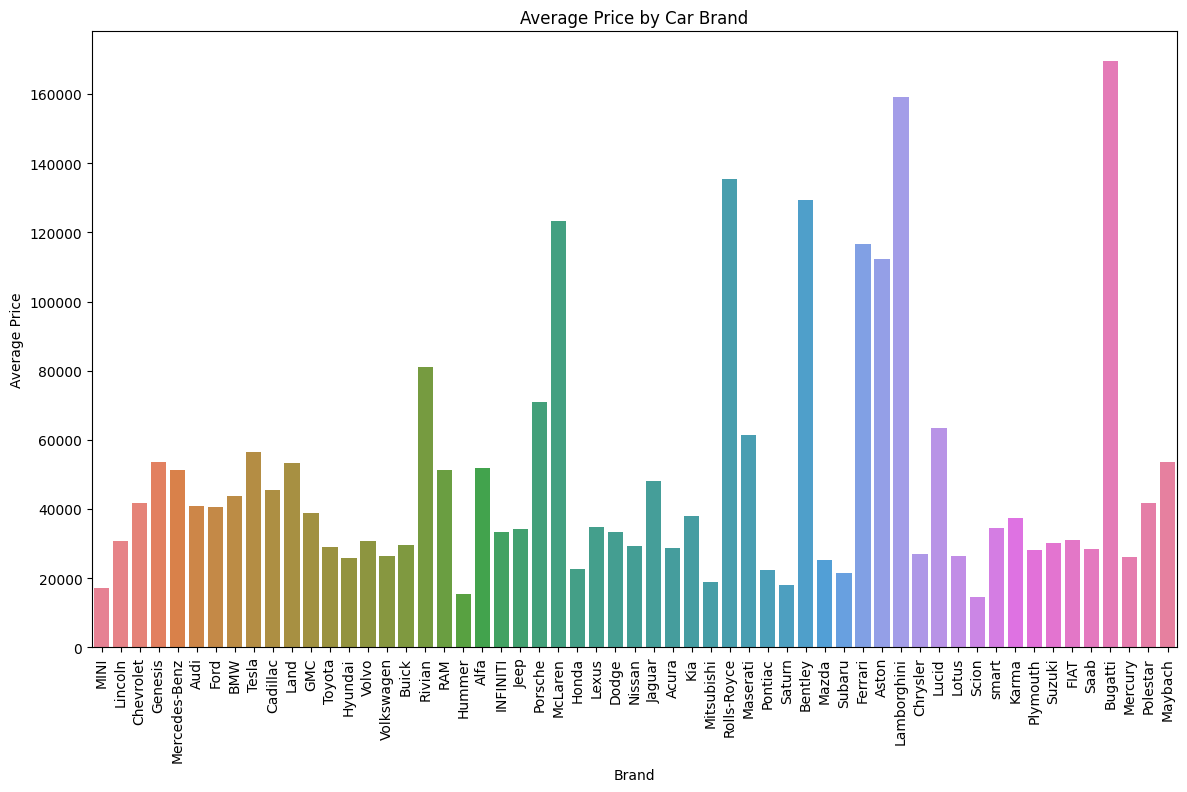

In [49]:
plt.figure(figsize=(14, 8))
sns.barplot(x='brand', y='price', data=data, errorbar=None, hue='brand', legend=False)
plt.title('Average Price by Car Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=90)  
plt.show()

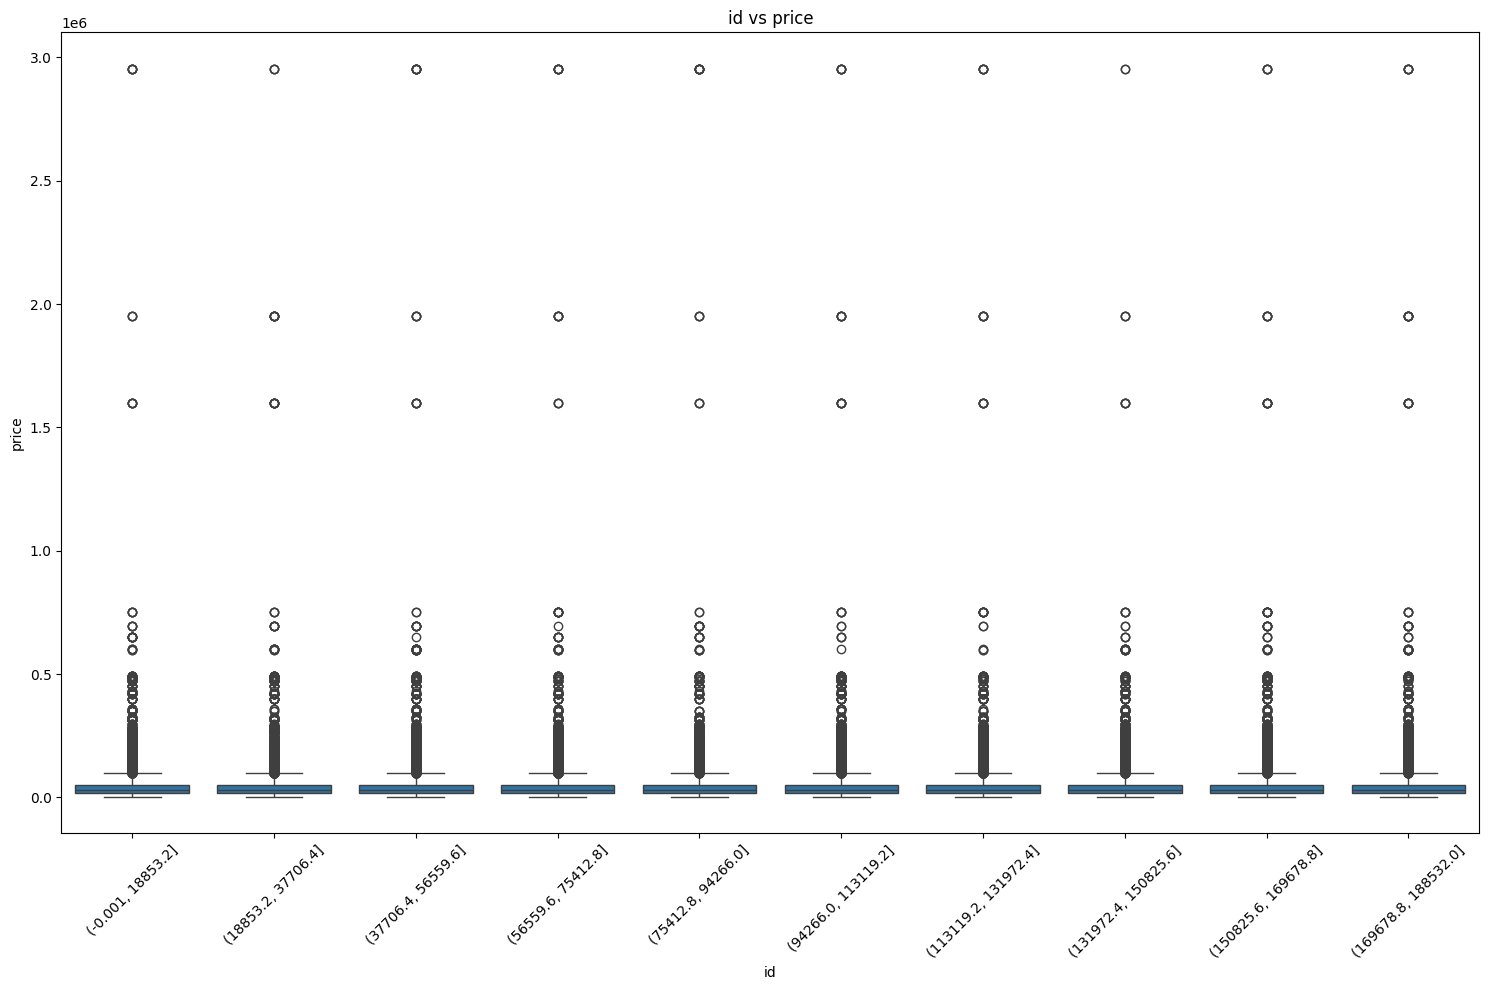

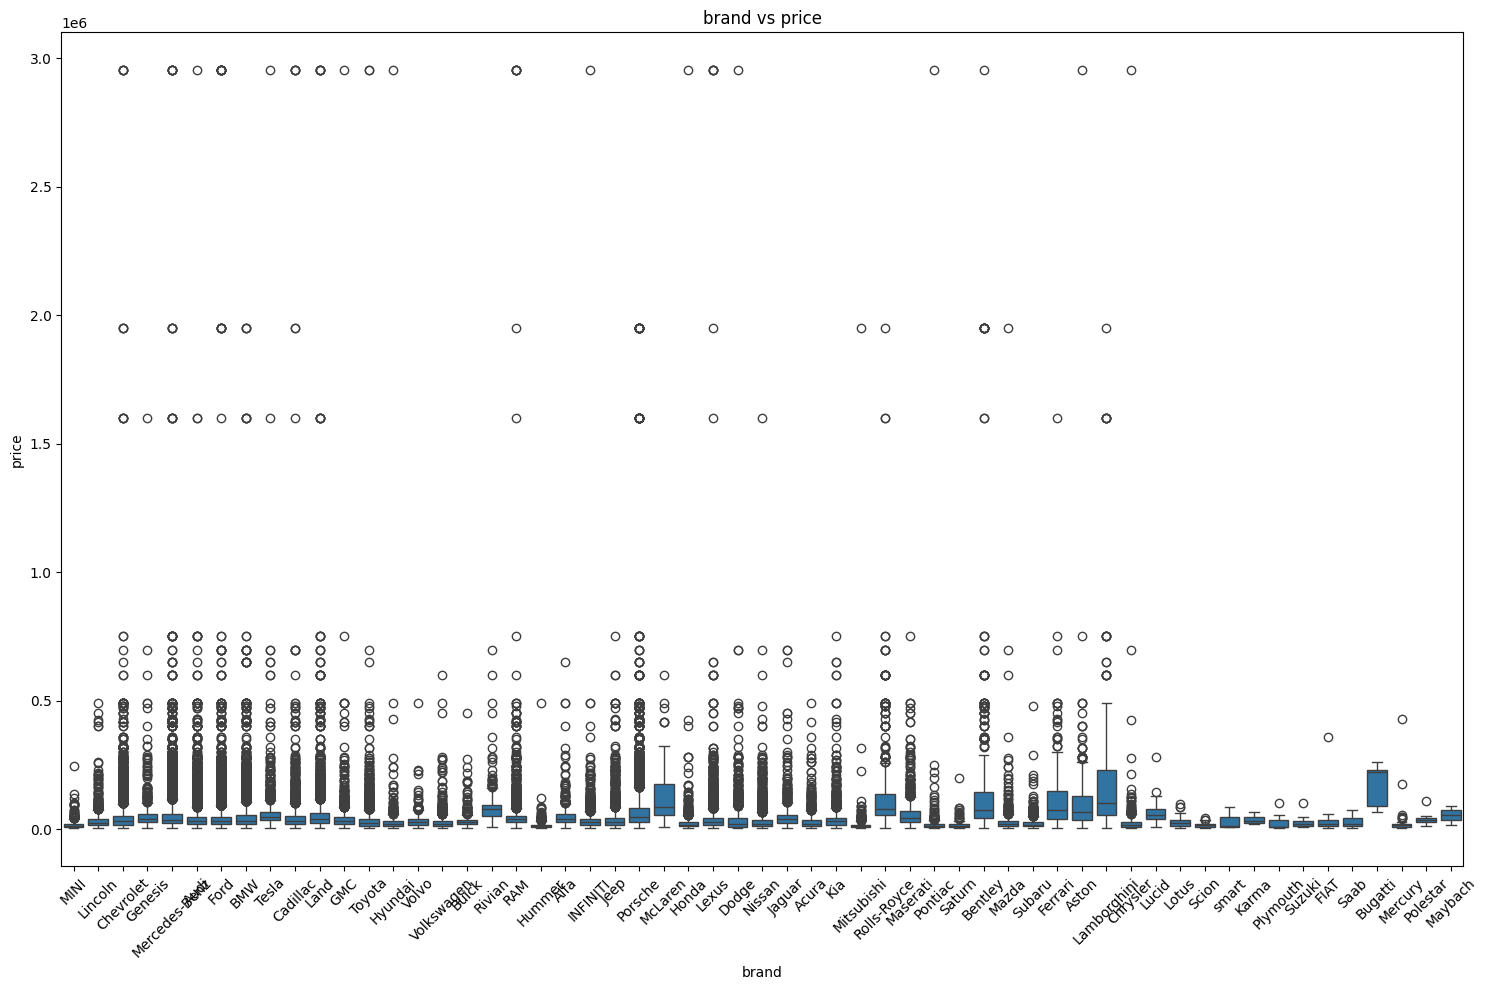

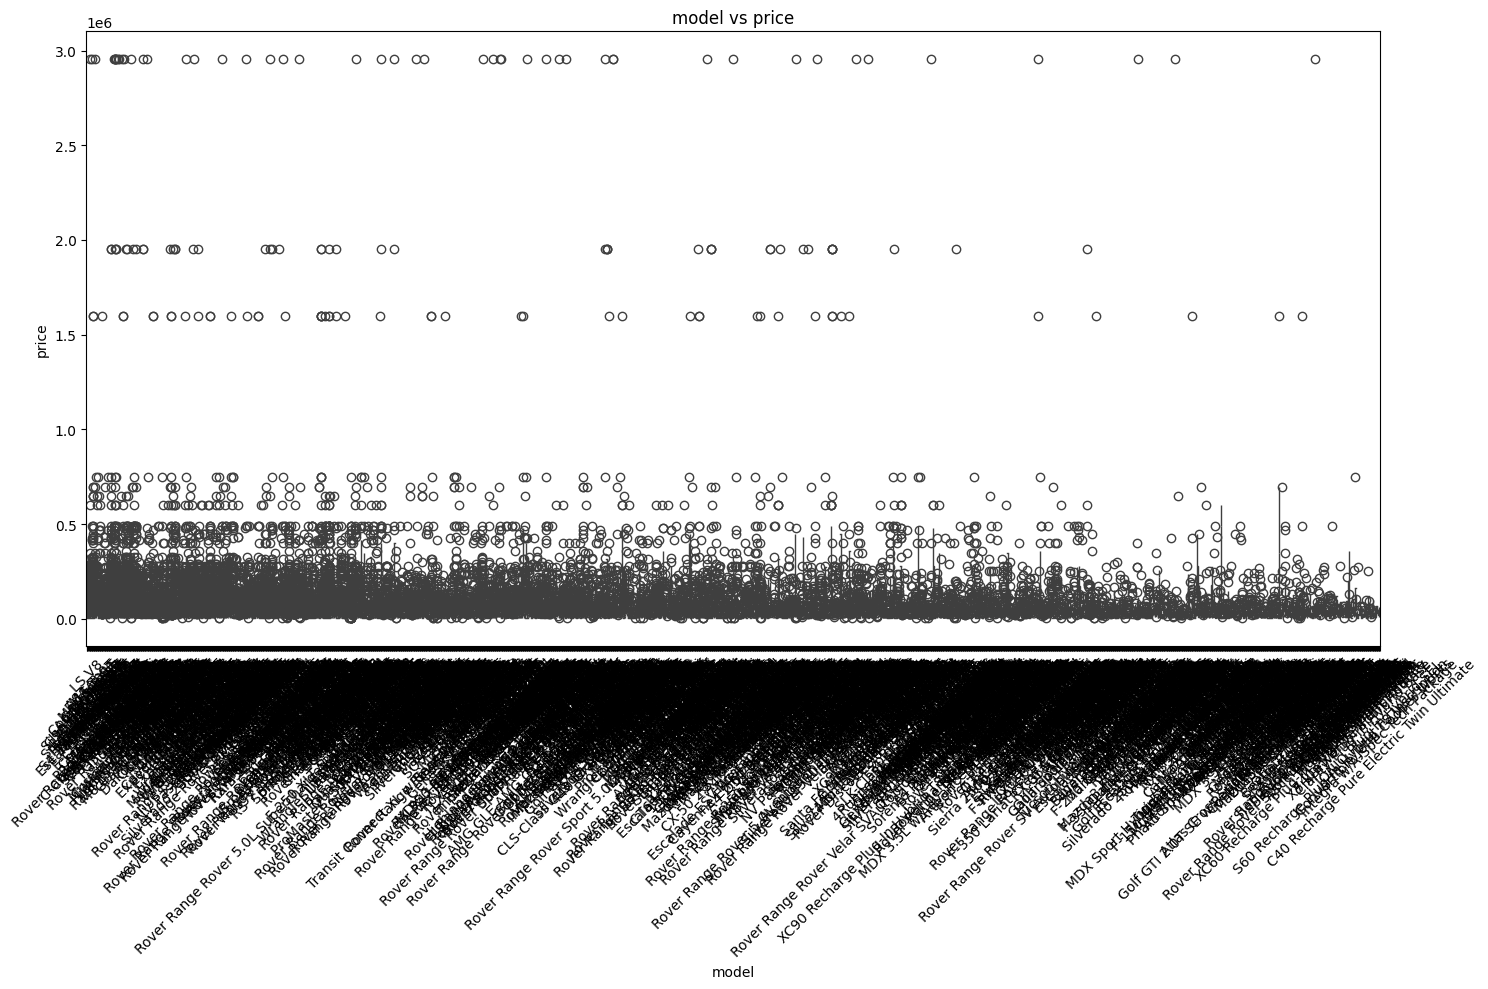

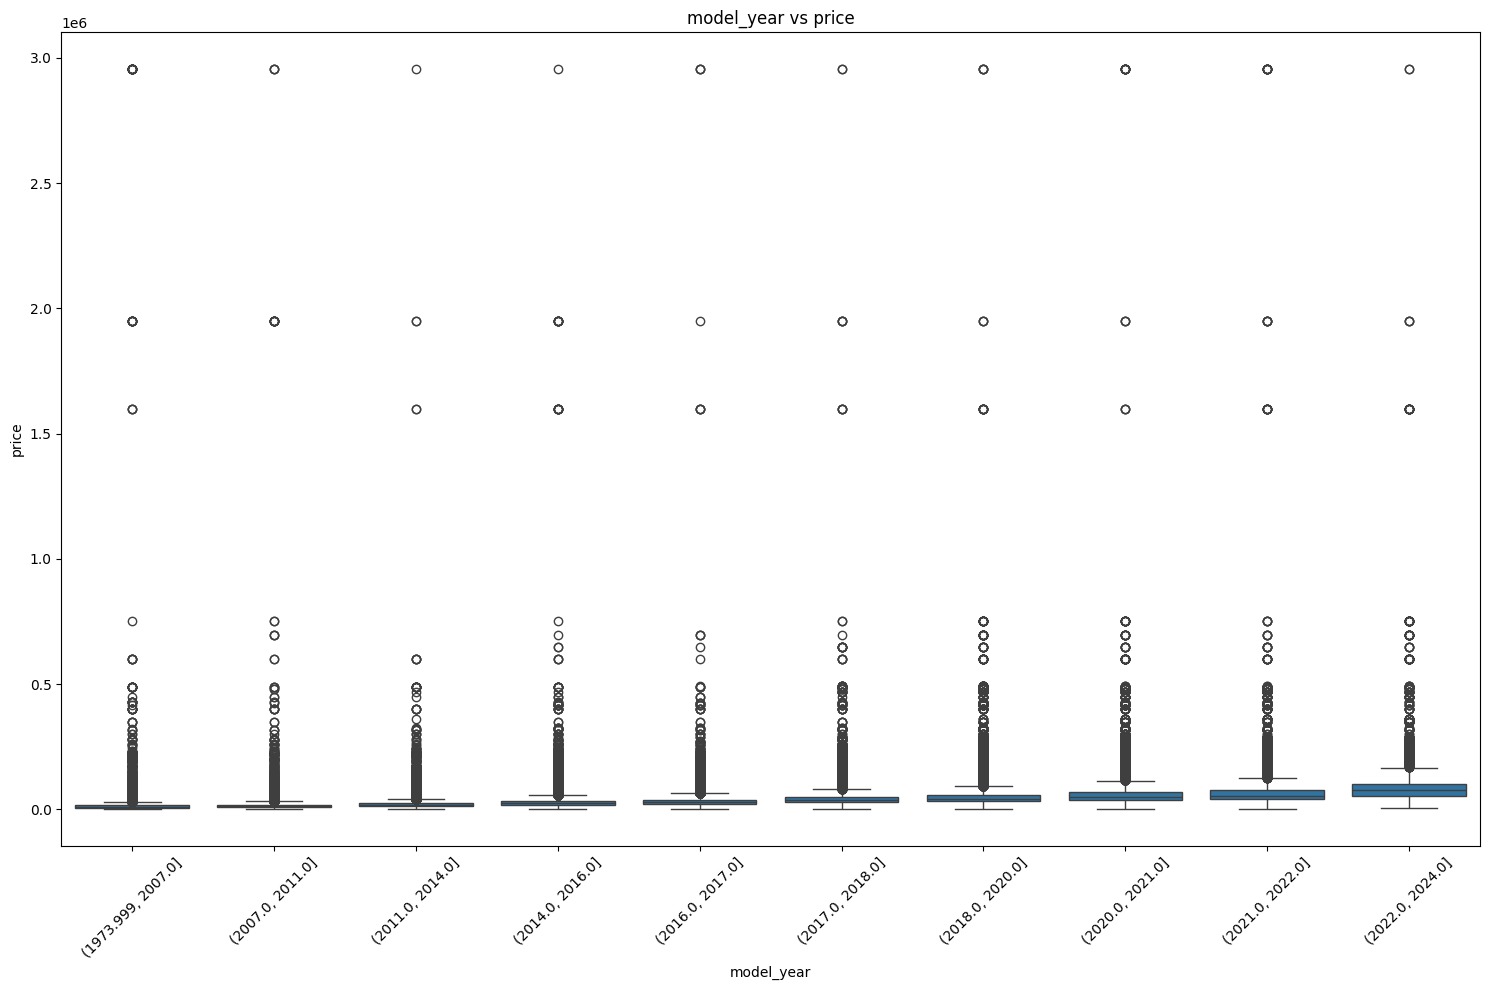

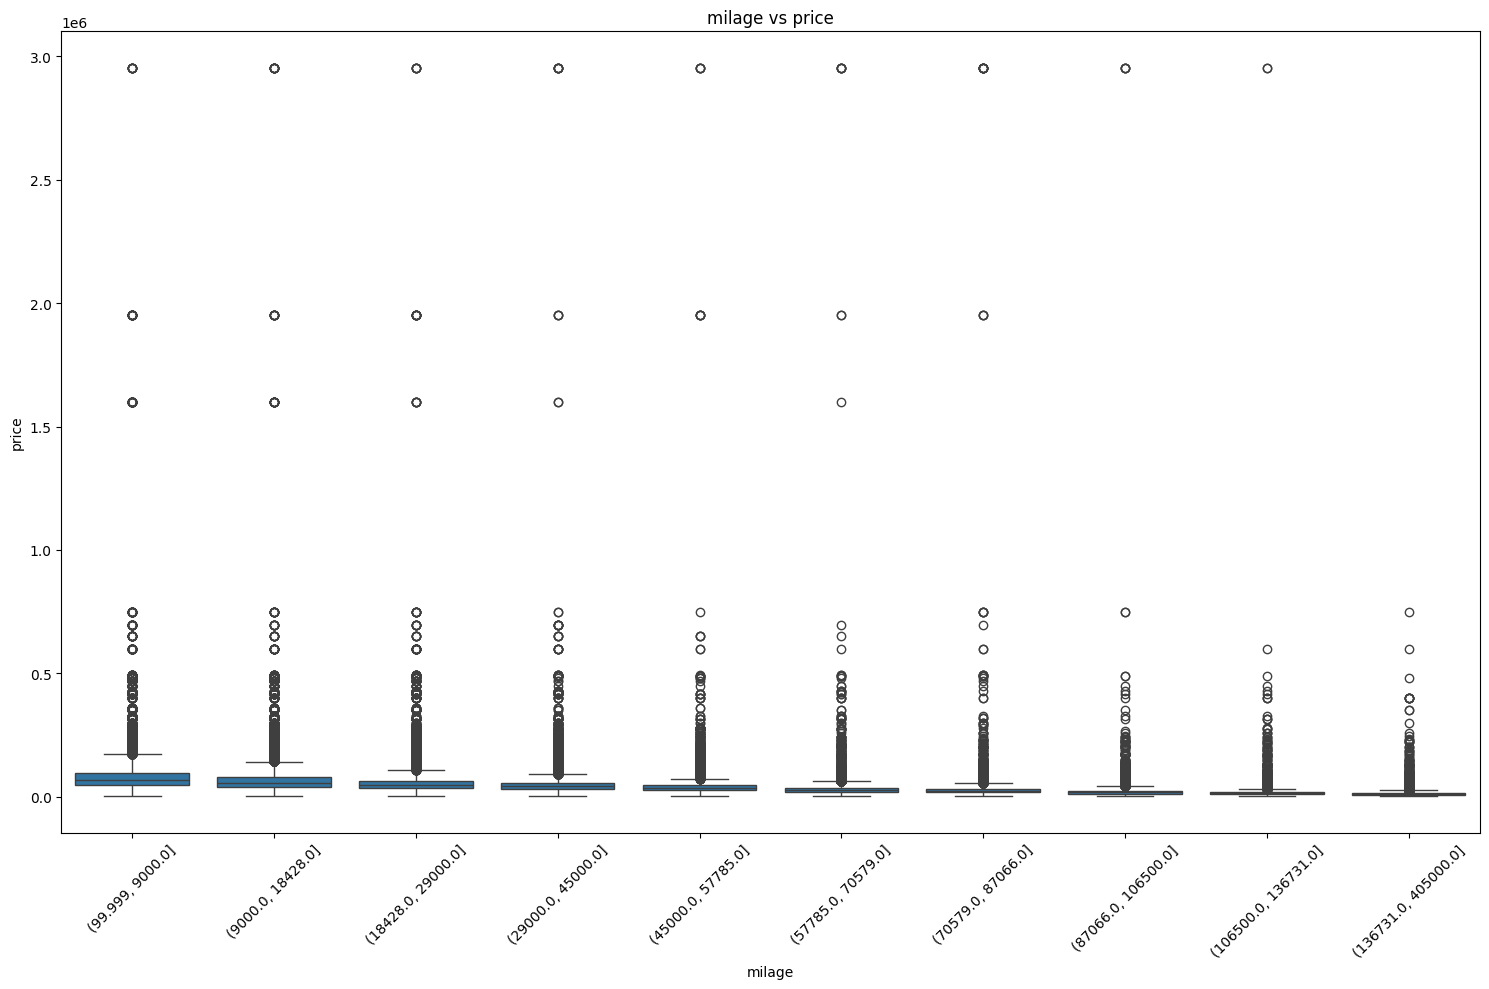

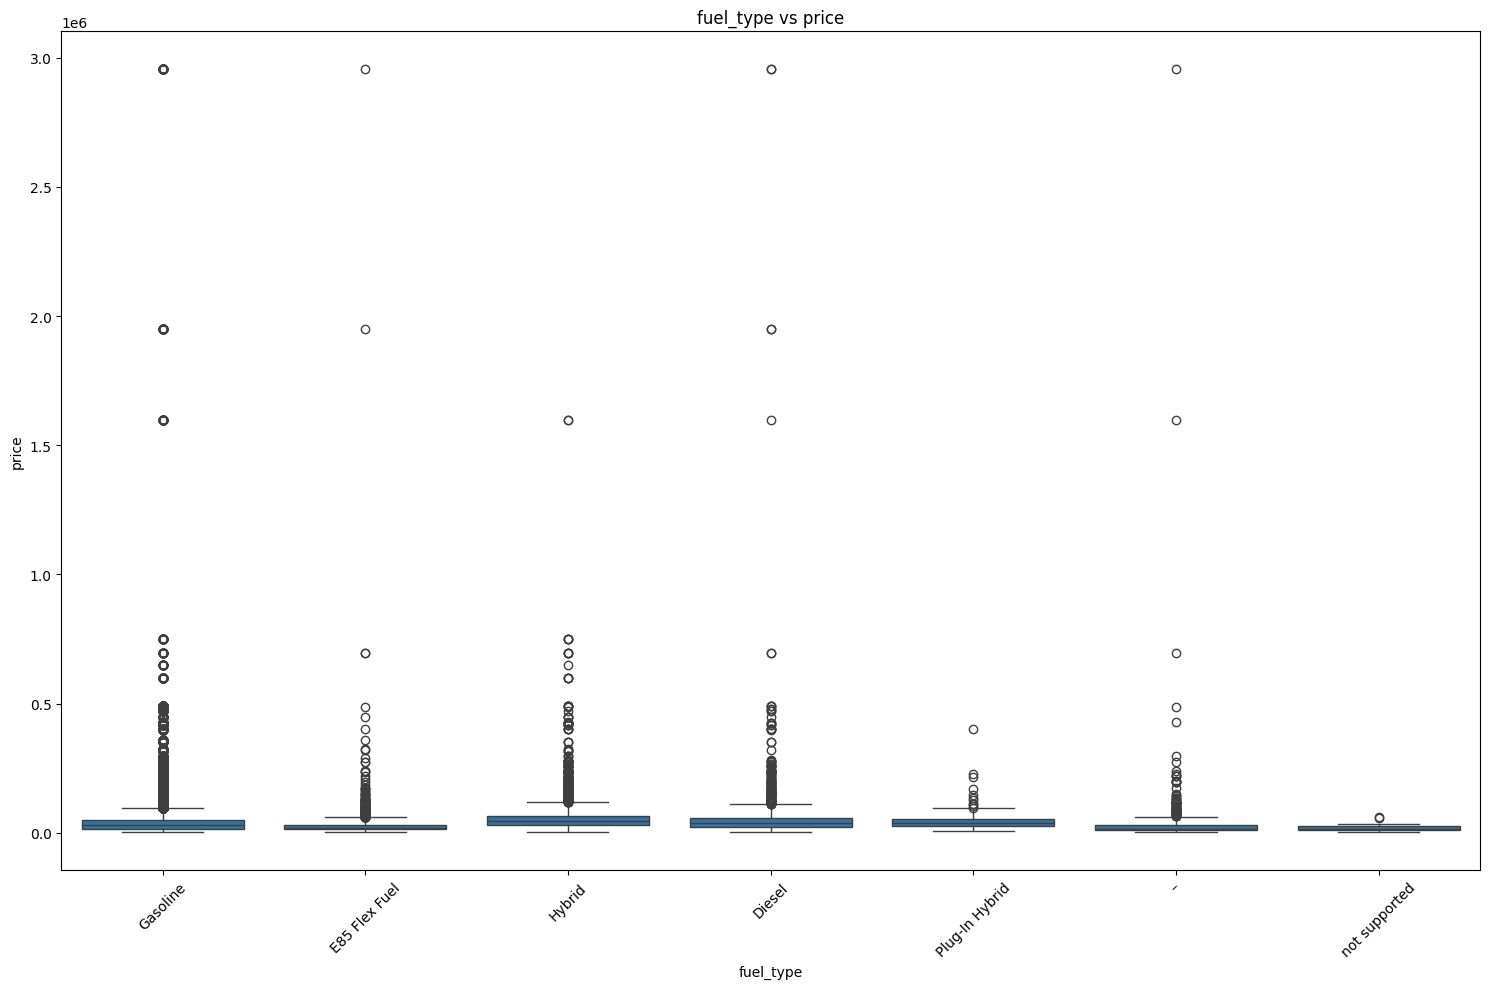

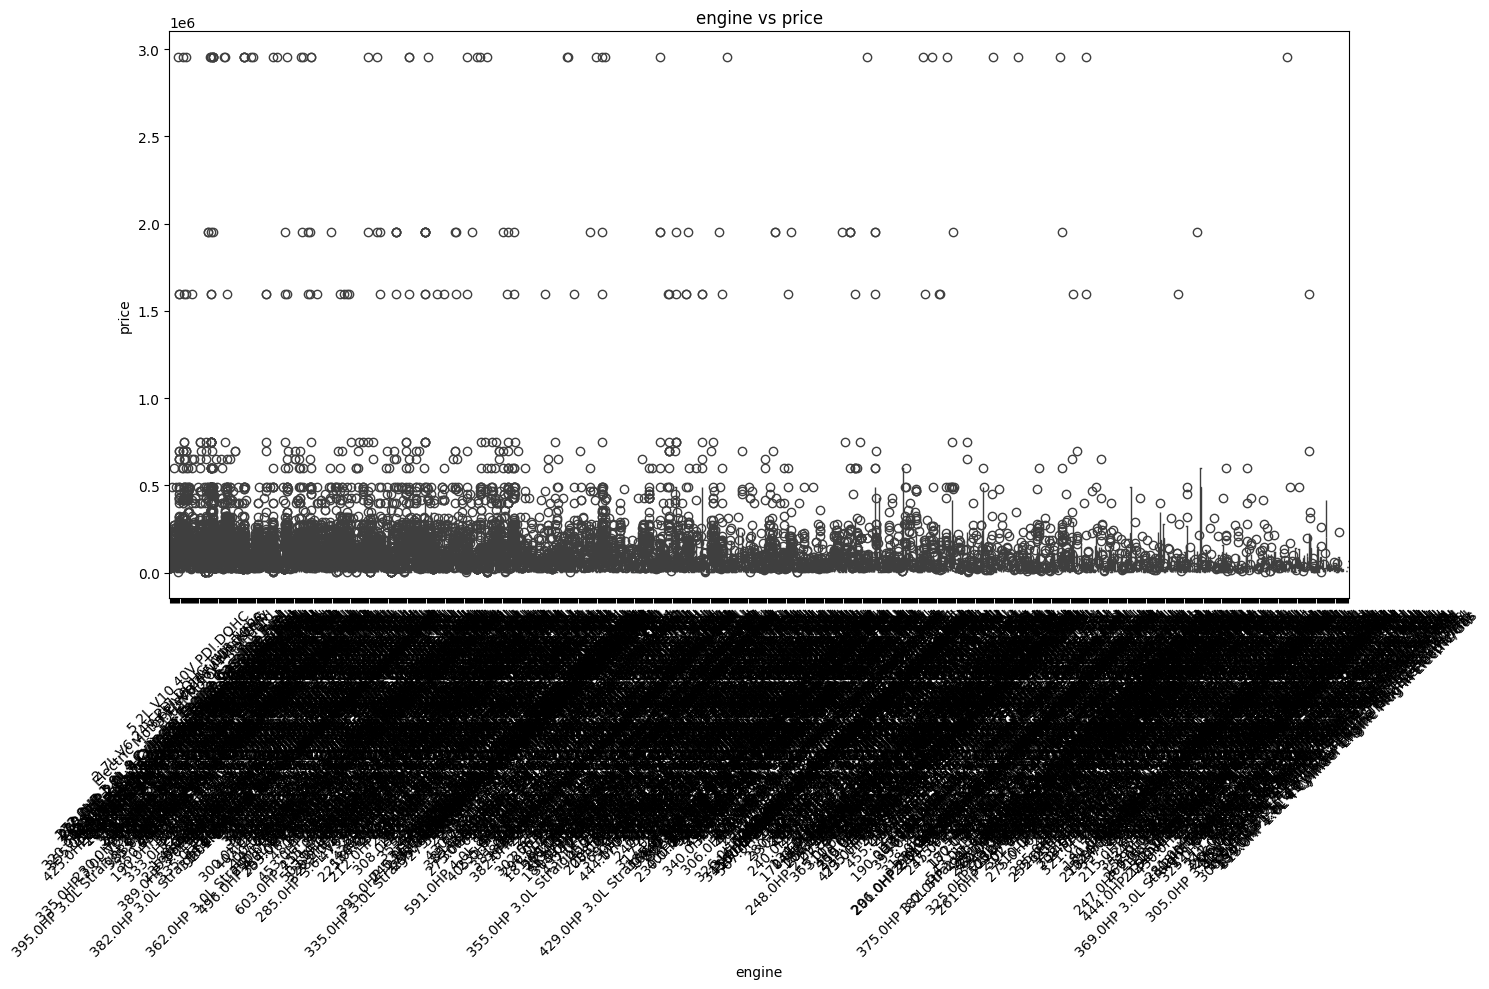

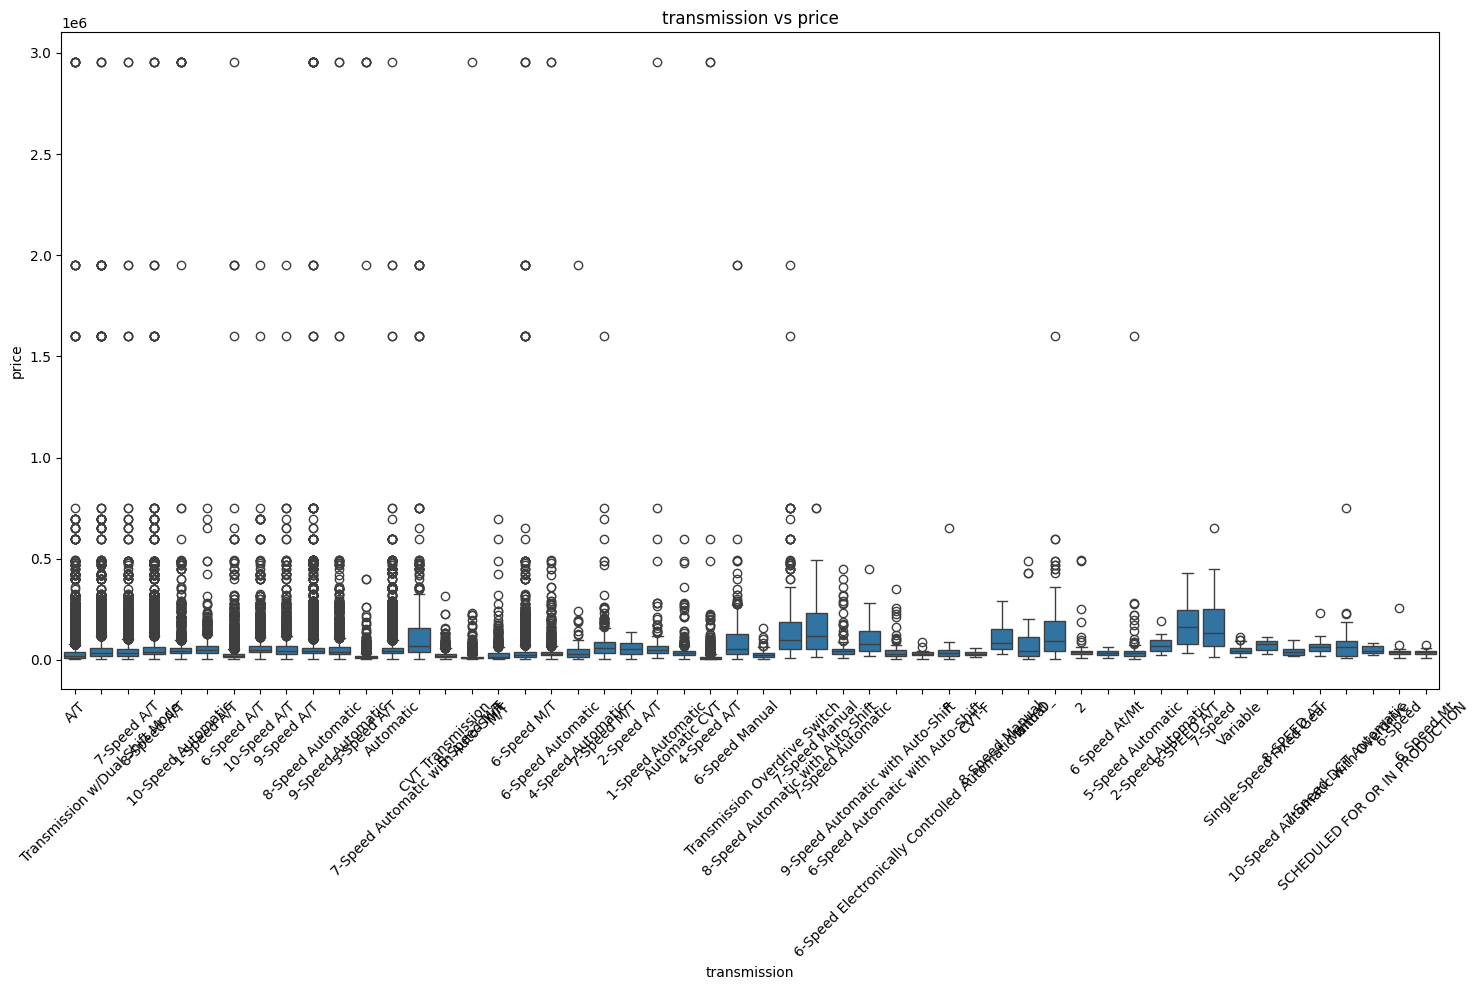

KeyboardInterrupt: 

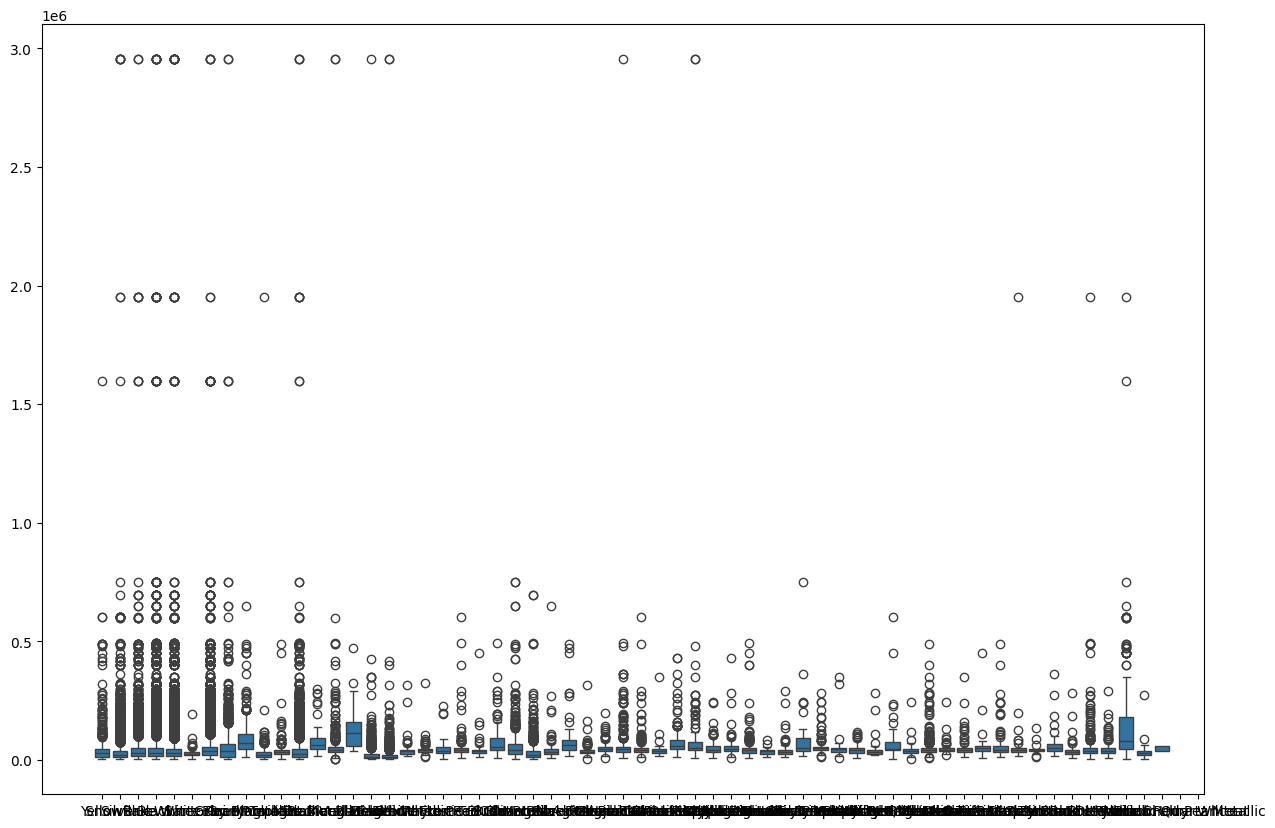

In [50]:
def plot_boxplots(data, target='price', figsize=(15, 10)):
    # Get all columns except the target
    features = [col for col in data.columns if col != target]
    
    # Plot each feature separately
    for feature in features:
        plt.figure(figsize=figsize)
        
        # Check if the feature is numeric and has too many unique values
        if pd.api.types.is_numeric_dtype(data[feature]) and data[feature].nunique() > 20:
            # For continuous variables, create bins
            data['binned'] = pd.qcut(data[feature], q=10, duplicates='drop')
            sns.boxplot(x='binned', y=target, data=data)
            plt.xticks(rotation=45)
            # Remove temporary binned column
            data.drop('binned', axis=1, inplace=True)
        else:
            # For categorical/discrete variables, use as is
            sns.boxplot(x=feature, y=target, data=data)
            plt.xticks(rotation=45)
        
        plt.title(f'{feature} vs {target}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()

# Use the function
plot_boxplots(data)

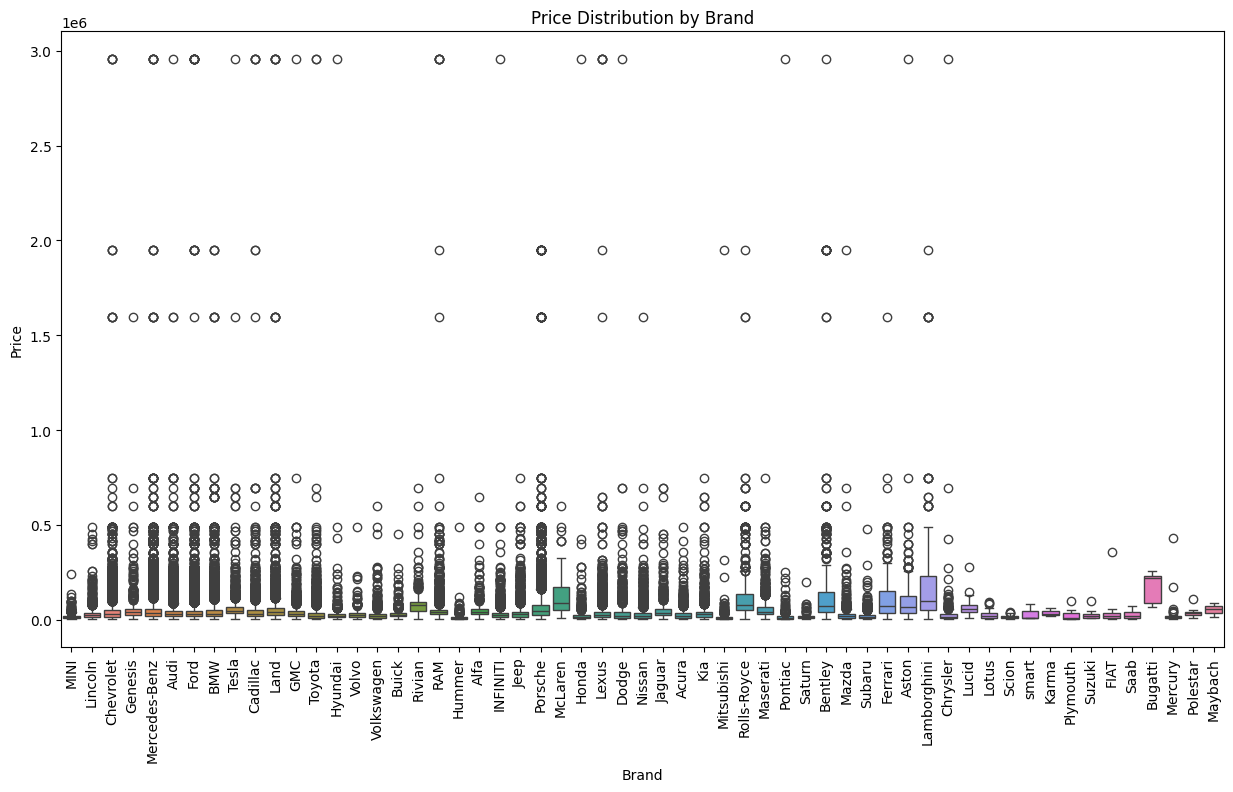

In [10]:
# Box plot for price by car brand
plt.figure(figsize=(15, 8))
sns.boxplot(data=data, x='brand', y='price', hue='brand', legend=False)
plt.xticks(rotation=90)
plt.title("Price Distribution by Brand")
plt.xlabel("Brand")
plt.ylabel("Price")
plt.show()

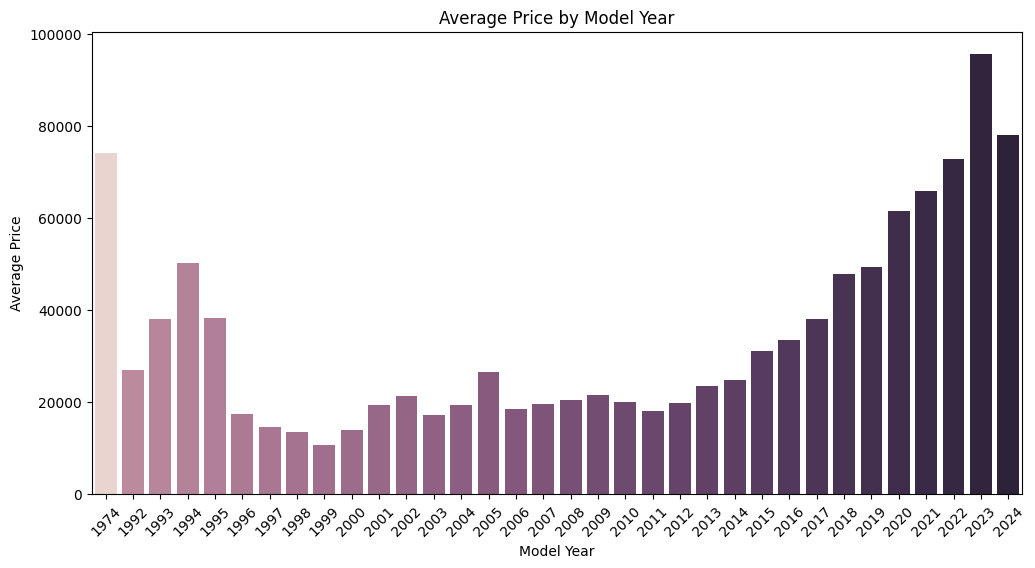

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model_year', y='price', data=data, errorbar=None, hue='model_year', legend=False)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

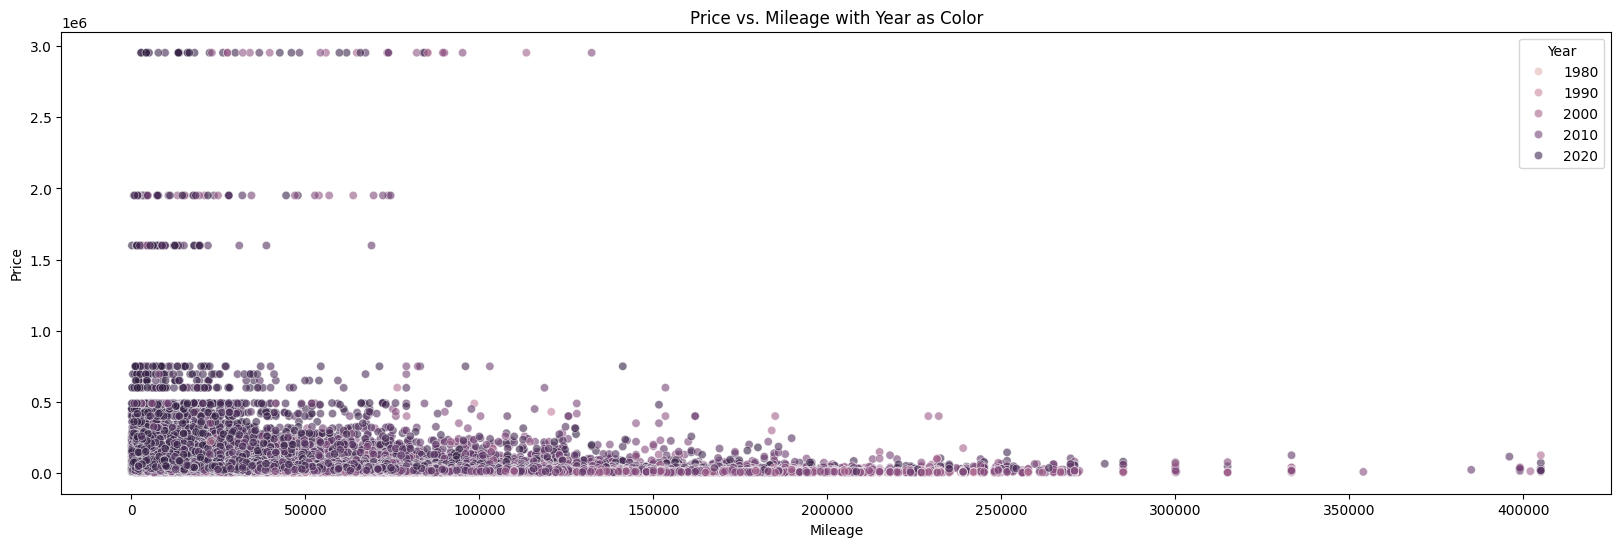

In [12]:
# Scatter plot of Price vs Mileage
plt.figure(figsize=(20, 6))
sns.scatterplot(data=data, x='milage', y='price', hue='model_year', alpha=0.6)
plt.title("Price vs. Mileage with Year as Color")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.legend(title="Year")
plt.show()

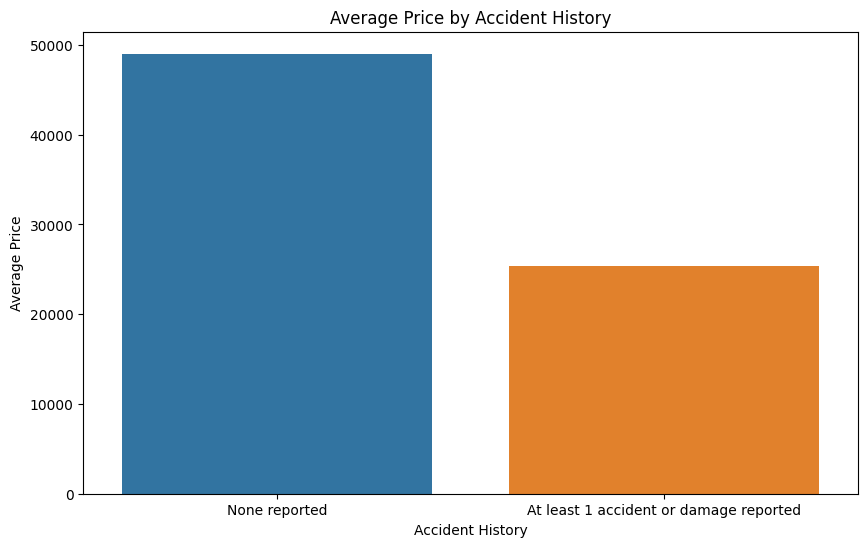

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='accident', y='price', data=data, errorbar=None, hue='accident', legend=False)
plt.title('Average Price by Accident History')
plt.xlabel('Accident History')
plt.ylabel('Average Price')
plt.show()

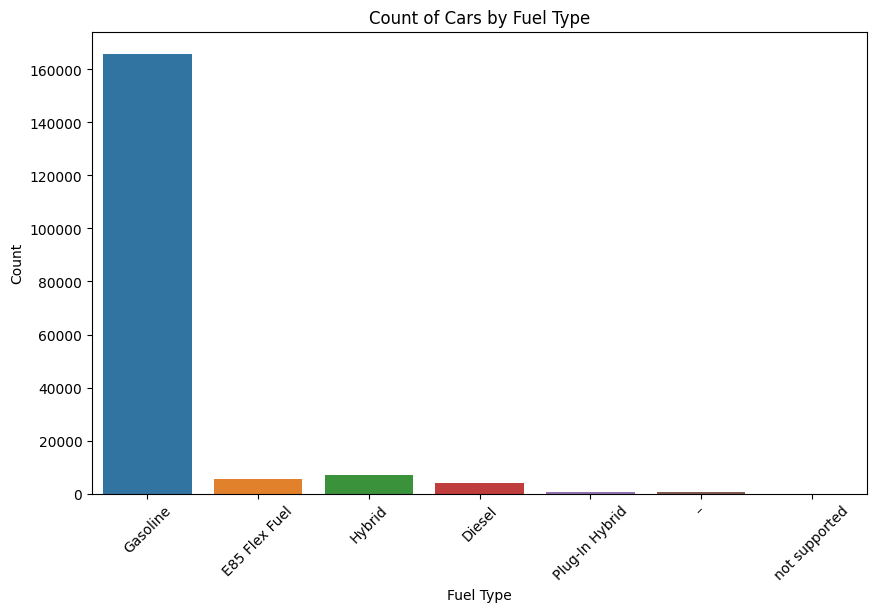

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=data, hue='fuel_type', legend=False)
plt.title('Count of Cars by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Feature extraction

In [15]:
def vehicle_age(df):
    current_year = 2024

    df['vehicle_age'] = current_year - df['model_year']
    df = df.drop(columns=['model_year'])

    return df

def engine_info(engine_total):
    HP_str = re.search(r'(\d+\.?\d*)HP', engine_total)
    size_str = re.search(r'(\d+\.?\d*)L', engine_total)
    cylinder_str = re.search(r'(\d+) Cylinder', engine_total)

    HP = float(HP_str.group(1)) if HP_str else None
    size = float(size_str.group(1)) if size_str else None
    cylinder = int(cylinder_str.group(1)) if cylinder_str else None

    return HP, size, cylinder

def process_transmission_data(data):
    # Create a DataFrame of unique transmissions
    data_transmission = pd.DataFrame(data['transmission'].unique().tolist(), columns=['Transmission'])
    
    # Feature 1: Extract the number of gears
    data_transmission['speed'] = data_transmission['Transmission'].apply(lambda x: re.search(r'\d+', x).group() if re.search(r'\d+', x) else None)
    
    # Feature 2: Identify transmission type (automatic, manual, CVT)
    data_transmission['transmission_type'] = data_transmission['Transmission'].apply(
        lambda x: 'Automatic' if 'A/T' in x or 'Automatic' in x or 'CVT' in x 
                  else 'Manual' if 'M/T' in x or 'Manual' in x 
                  else 'Other'
    )
    
    # Concatenate the new features with the original data
    data = pd.concat([data, data_transmission[['speed', 'transmission_type']]], axis=1)

    # Drop the "transmission" column
    data = data.drop(columns=['transmission'])
    
    return data

def extract_brand_features(df):
    average_price_per_brand = df.groupby('brand')['price'].mean().reset_index()
    overall_average_price = df['price'].mean()

    # Create brand tier categories (luxury, premium, economy)
    luxury_brands = average_price_per_brand[average_price_per_brand['price'] > (1.5 *overall_average_price)]['brand'].tolist()
    premium_brands = average_price_per_brand[(average_price_per_brand['price'] > overall_average_price) & (average_price_per_brand['price'] <= (1.5 * overall_average_price))]['brand'].tolist()
    economy_brands = average_price_per_brand[(average_price_per_brand['price'] <= overall_average_price) & (average_price_per_brand['price'] > (1/2 * overall_average_price))]['brand'].tolist()
    
    df['luxury_brand'] = df['brand'].apply(lambda x: 3 if x in luxury_brands else 2 if x in premium_brands else 1 if x in economy_brands else 0)

    df = df.drop(columns=['brand'])
    
    return df

In [16]:
# Add a column "vehicle_age" and drop the column "model_year"
data = vehicle_age(data)

# Add the columns "HP", "engine_size" and "cylinders" and drop the column "engine"
data[['HP', 'engine_size', 'cylinders']] = data['engine'].apply(lambda x: pd.Series(engine_info(x)))

data = data.drop(columns=['engine'])

# Add the columns "speed" and "transmission_type" and drop the column "transmission"
data = process_transmission_data(data)

# Add the columns "luxury_brand", "premium_brand" and "economy_brand" and drop the column "brand"
data = extract_brand_features(data)

In [17]:
data.head()

,id,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,luxury_brand
0,0,Cooper S Base,213000,Gasoline,Yellow,Gray,None reported,Yes,4200,17,172.0,1.6,4.0,None,Automatic,0
1,1,LS V8,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0,None,Other,1
2,2,Silverado 2500 LT,136731,E85 Flex Fuel,Blue,Gray,None reported,Yes,13900,22,320.0,5.3,8.0,7,Automatic,1
3,3,G90 5.0 Ultimate,19500,Gasoline,Black,Black,None reported,Yes,45000,7,420.0,5.0,8.0,8,Automatic,2
4,4,Metris Base,7388,Gasoline,Black,Beige,None reported,Yes,97500,3,208.0,2.0,4.0,10,Automatic,2


In [18]:
# Replace '-' with 'Electric' in the "fuel_type" because electric is mentioned in the "Data card" of the dataset and it is not in the values, so it must be the '-'
print('Fuel types pre processing:', data['fuel_type'].unique())
data['fuel_type'] = data['fuel_type'].fillna('Unknown')
data['fuel_type'] = data['fuel_type'].replace('–', 'Electric')
print('Fuel types post processing:', data['fuel_type'].unique())

print()

# Accidents
print('Accidents pre processing:', data['accident'].unique())
data['accident'] = data['accident'].fillna('Unknown')
print('Accidents post processing:', data['accident'].unique())

print()

# Clean title
print('Clean title pre processing:', data['clean_title'].unique())
data['clean_title'] = data['clean_title'].fillna('Unknown')
print('Clean title post processing:', data['clean_title'].unique())

print()

# HP
print('HP pre processing:', data['HP'].unique())
data['HP'] = data['HP'].fillna(0)
print('HP processing', data['HP'].unique())

print()

# Engine size
print('Engine size pre processing:', data['engine_size'].unique())
data['engine_size'] = data['engine_size'].fillna(0)
print('Engine size processing', data['engine_size'].unique())

print()

# Cylinders
print('Cylinders pre processing:', data['cylinders'].unique())
data['cylinders'] = data['cylinders'].fillna(0)
print('Cylinders processing', data['cylinders'].unique())

print()

# Speed
print('Speed pre processing:', data['speed'].unique())
data['speed'] = data['speed'].fillna('0')
print('Speed post processing', data['speed'].unique())

print()

# Transmission type
print('Transmission type pre processing:', data['transmission_type'].unique())
data['transmission_type'] = data['transmission_type'].fillna('Unknown')
print('Transmission type post processing', data['transmission_type'].unique())

Fuel types pre processing: ['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']
Fuel types post processing: ['Gasoline' 'E85 Flex Fuel' 'Unknown' 'Hybrid' 'Diesel' 'Plug-In Hybrid'
 'Electric' 'not supported']

Accidents pre processing: ['None reported' 'At least 1 accident or damage reported' nan]
Accidents post processing: ['None reported' 'At least 1 accident or damage reported' 'Unknown']

Clean title pre processing: ['Yes' nan]
Clean title post processing: ['Yes' 'Unknown']

HP pre processing: [ 172.  252.  320.  420.  208.  333.  355.   nan  425.  312.  523.  503.
  395.  310.  469.  429.  210.  335.  316.  381.  450.  236.  211.  220.
  255.  518.  268.  174.  240.  248.  563.  241.  230.  430.  835.  300.
  280.  295.  348.  560.  285.  302.  490.  200.  416.  179.  385.  160.
  270.  350.  190.  181.  265.  345.  400.  261.  536.  402.  382.  180.
  617.  173.  389.  318.  325.  365.  340.  235.  169.  710.  225.  366.
  284.  260.  670.  48

In [19]:
print('TRAIN SET:')
print(data.isnull().sum())

TRAIN SET:
id                   0
model                0
milage               0
fuel_type            0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
vehicle_age          0
HP                   0
engine_size          0
cylinders            0
speed                0
transmission_type    0
luxury_brand         0
dtype: int64

TEST SET:
id                   0
brand                0
model                0
milage               0
fuel_type            0
ext_col              0
int_col              0
accident             0
clean_title          0
vehicle_age          0
HP                   0
engine_size          0
cylinders            0
speed                0
transmission_type    0
dtype: int64


In [20]:
# drop columns that I think that are not useful (the color of the car can be changed and usually it is a cheap optional)
data = data.drop(columns=['id', 'clean_title', 'ext_col', 'int_col', 'model'])

In [21]:
data.head()

,milage,fuel_type,accident,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,luxury_brand
0,213000,Gasoline,None reported,4200,17,172.0,1.6,4.0,0,Automatic,0
1,143250,Gasoline,At least 1 accident or damage reported,4999,22,252.0,3.9,8.0,0,Other,1
2,136731,E85 Flex Fuel,None reported,13900,22,320.0,5.3,8.0,7,Automatic,1
3,19500,Gasoline,None reported,45000,7,420.0,5.0,8.0,8,Automatic,2
4,7388,Gasoline,None reported,97500,3,208.0,2.0,4.0,10,Automatic,2


## Encode the non-numerical features

In [22]:
# Encode the accident column as 1 if 'At least 1 accident or damage reported', else 0
data['accident'] = data['accident'].apply(lambda x: 1 if x=='At least 1 accident or damage reported' else 0)

In [23]:
# Transform the column 'speed' to numerical data, it was a column of strings before
data['speed'] = data['speed'].replace('Unknown', 0)
data['speed'] = pd.to_numeric(data['speed'])

In [25]:
# Encode the 'transmission_type' as 1 if it is 'Automatic', 0 if it is 'Manual' or else
data['transmission_type'] = data['transmission_type'].apply(lambda x: 1 if x=='Automatic' else 0)

In [26]:
from sklearn.preprocessing import RobustScaler

columns_to_standardize = ['milage', 'vehicle_age', 'HP', 'engine_size']

scaler = RobustScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

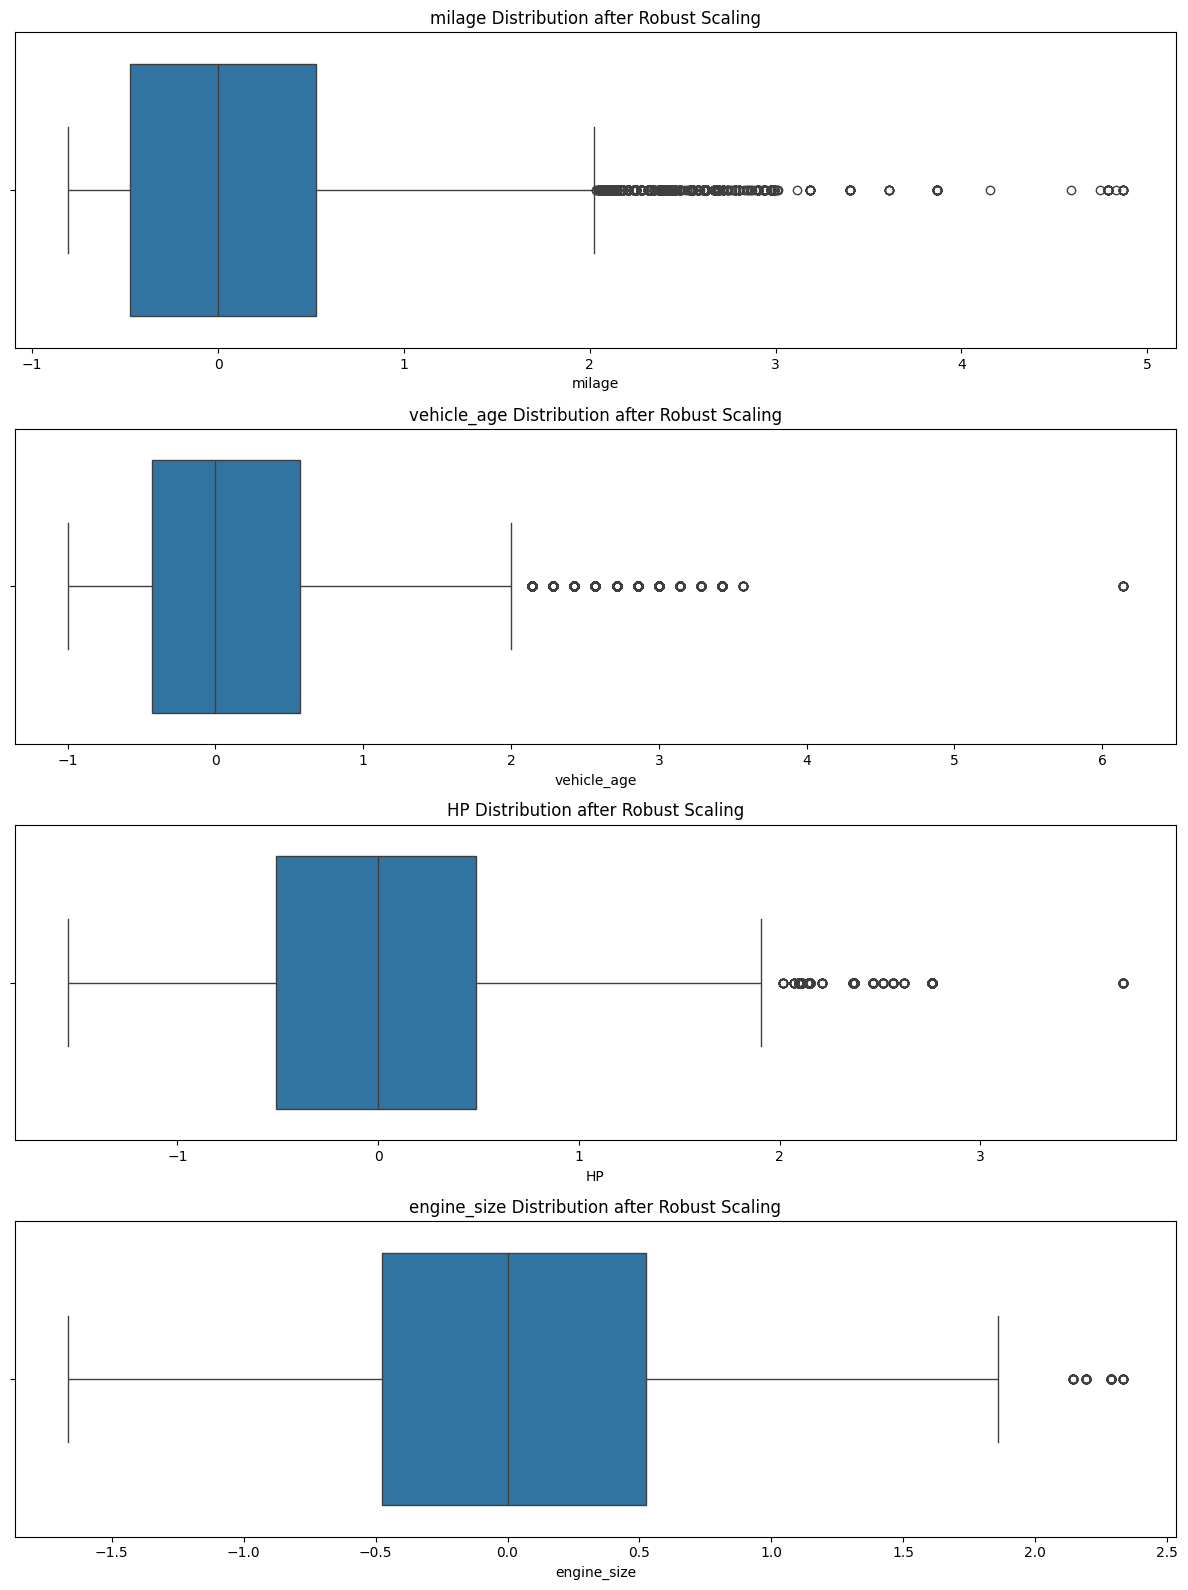

In [27]:
fig, axes = plt.subplots(len(columns_to_standardize), 1, figsize=(12, 4*len(columns_to_standardize)))

for i, column in enumerate(columns_to_standardize):
    sns.boxplot(data=data, x=column, ax=axes[i])
    axes[i].set_title(f'{column} Distribution after Robust Scaling')

plt.tight_layout()
plt.show()

In [29]:
data.head()

,milage,fuel_type,accident,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,luxury_brand
0,0.525809,Gasoline,0,4200,0.34,0.168627,0.190476,4.0,0,0,0
1,0.353544,Gasoline,1,4999,0.44,0.247059,0.464286,8.0,0,0,1
2,0.337444,E85 Flex Fuel,0,13900,0.44,0.313725,0.630952,8.0,7,0,1
3,0.047913,Gasoline,0,45000,0.14,0.411765,0.595238,8.0,8,0,2
4,0.018000,Gasoline,0,97500,0.06,0.203922,0.238095,4.0,10,0,2


In [30]:
categorical_columns = ['fuel_type', 'luxury_brand']

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
#data_test_encoded = pd.get_dummies(data_test, columns=categorical_columns, drop_first=True)


# Replace True with 1 and False with 0
data_encoded = data_encoded.replace({True: 1, False: 0})
#data_test_encoded = data_test_encoded.replace({True: 1, False: 0})

/var/folders/_g/7s4z636d67z67rlmmnqgx5mm0000gn/T/ipykernel_30498/665963600.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data_encoded.replace({True: 1, False: 0})


In [31]:
data_encoded.head()

,milage,accident,price,vehicle_age,HP,engine_size,cylinders,speed,transmission_type,fuel_type_E85 Flex Fuel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_Unknown,fuel_type_not supported,luxury_brand_1,luxury_brand_2,luxury_brand_3
0,0.525809,0,4200,0.34,0.168627,0.190476,4.0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.353544,1,4999,0.44,0.247059,0.464286,8.0,0,0,0,0,1,0,0,0,0,1,0,0
2,0.337444,0,13900,0.44,0.313725,0.630952,8.0,7,0,1,0,0,0,0,0,0,1,0,0
3,0.047913,0,45000,0.14,0.411765,0.595238,8.0,8,0,0,0,1,0,0,0,0,0,1,0
4,0.018000,0,97500,0.06,0.203922,0.238095,4.0,10,0,0,0,1,0,0,0,0,0,1,0


In [32]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   milage                    188533 non-null  float64
 1   accident                  188533 non-null  int64  
 2   price                     188533 non-null  int64  
 3   vehicle_age               188533 non-null  float64
 4   HP                        188533 non-null  float64
 5   engine_size               188533 non-null  float64
 6   cylinders                 188533 non-null  float64
 7   speed                     188533 non-null  int64  
 8   transmission_type         188533 non-null  int64  
 9   fuel_type_E85 Flex Fuel   188533 non-null  int64  
 10  fuel_type_Electric        188533 non-null  int64  
 11  fuel_type_Gasoline        188533 non-null  int64  
 12  fuel_type_Hybrid          188533 non-null  int64  
 13  fuel_type_Plug-In Hybrid  188533 non-null  i

## Create X_train and y_train

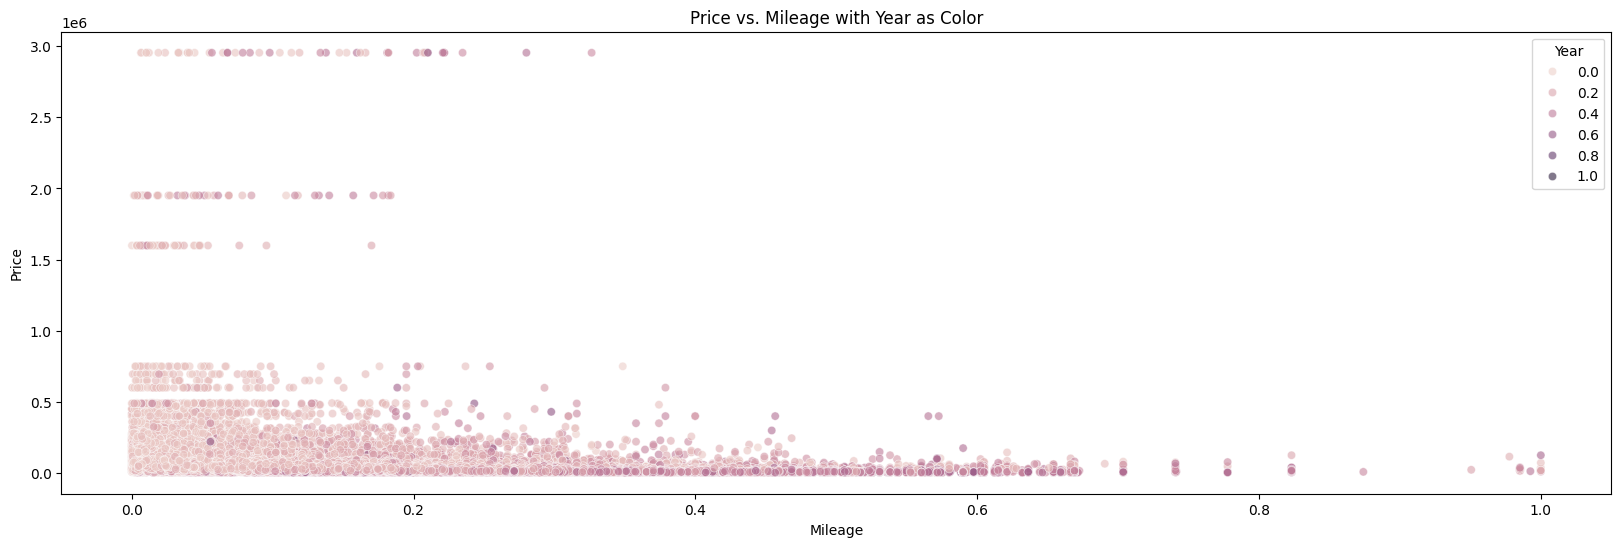

In [51]:
# Scatter plot of Price vs Mileage
plt.figure(figsize=(20, 6))
sns.scatterplot(data=data_encoded, x='milage', y='price', hue='vehicle_age', alpha=0.6)
plt.title("Price vs. Mileage with Year as Color")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.legend(title="Year")
plt.show()

In [52]:
X = data_encoded.drop(columns=['price'])
y = data_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Create, train and evaluate model

In [53]:

def plot_results(train_rmse, test_rmse, ytrain, ytest, ytrainpred, ytestpred):
    rmse_values = [train_rmse, test_rmse]
    labels = ['Train RMSE', 'Test RMSE']

    # Plot RMSE Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(labels, rmse_values, color=['blue', 'orange'])
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison')
    plt.show()

    # Plot Predictions vs True Values for Training and Testing sets separately
    # Determine the y-axis limits for training and test sets
    train_ylim = (min(min(ytrain), min(ytrainpred)), max(max(ytrain), max(ytrainpred)))
    test_ylim = (min(min(ytest), min(ytestpred)), max(max(ytest), max(ytestpred)))

    plt.figure(figsize=(14, 10))

    # 1. Training Set True Values
    plt.subplot(2, 2, 1)
    plt.plot(range(len(ytrain)), ytrain, 'o', color='blue', markersize=5, label='True Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Training Set: True Values')
    plt.ylim(train_ylim)  # Set y-axis limits for training
    plt.grid()
    plt.legend()

    # 2. Training Set Predicted Values
    plt.subplot(2, 2, 2)
    plt.plot(range(len(ytrainpred)), ytrainpred, 'o', color='red', markersize=5, label='Predicted Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Training Set: Predicted Values')
    plt.ylim(train_ylim)  # Set y-axis limits for training
    plt.grid()
    plt.legend()

    # 3. Test Set True Values
    plt.subplot(2, 2, 3)
    plt.plot(range(len(ytest)), ytest, 'o', color='blue', markersize=5, label='True Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Test Set: True Values')
    plt.ylim(test_ylim)  # Set y-axis limits for test
    plt.grid()
    plt.legend()

    # 4. Test Set Predicted Values
    plt.subplot(2, 2, 4)
    plt.plot(range(len(ytestpred)), ytestpred, 'o', color='red', markersize=5, label='Predicted Values')
    plt.xlabel('Element')
    plt.ylabel('Value')
    plt.title('Test Set: Predicted Values')
    plt.ylim(test_ylim)  # Set y-axis limits for test
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [54]:
# prepare a dataframe for the quality results
results = pd.DataFrame(columns=['Model','Train RMSE','Test RMSE'])

Train rmse 75474.14028174934
Test rmse 69844.10136018129


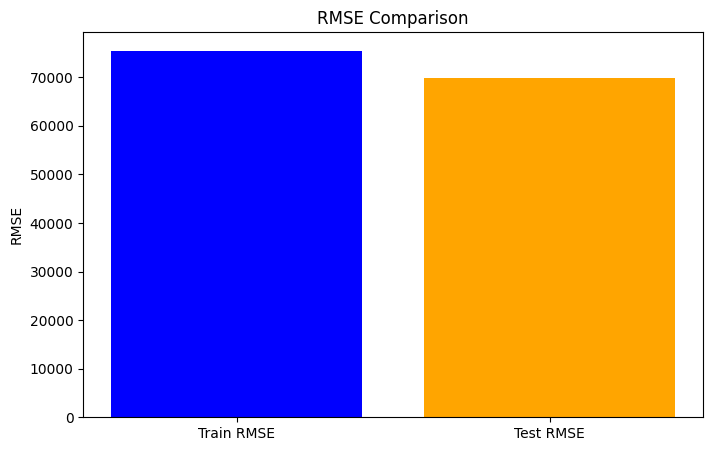

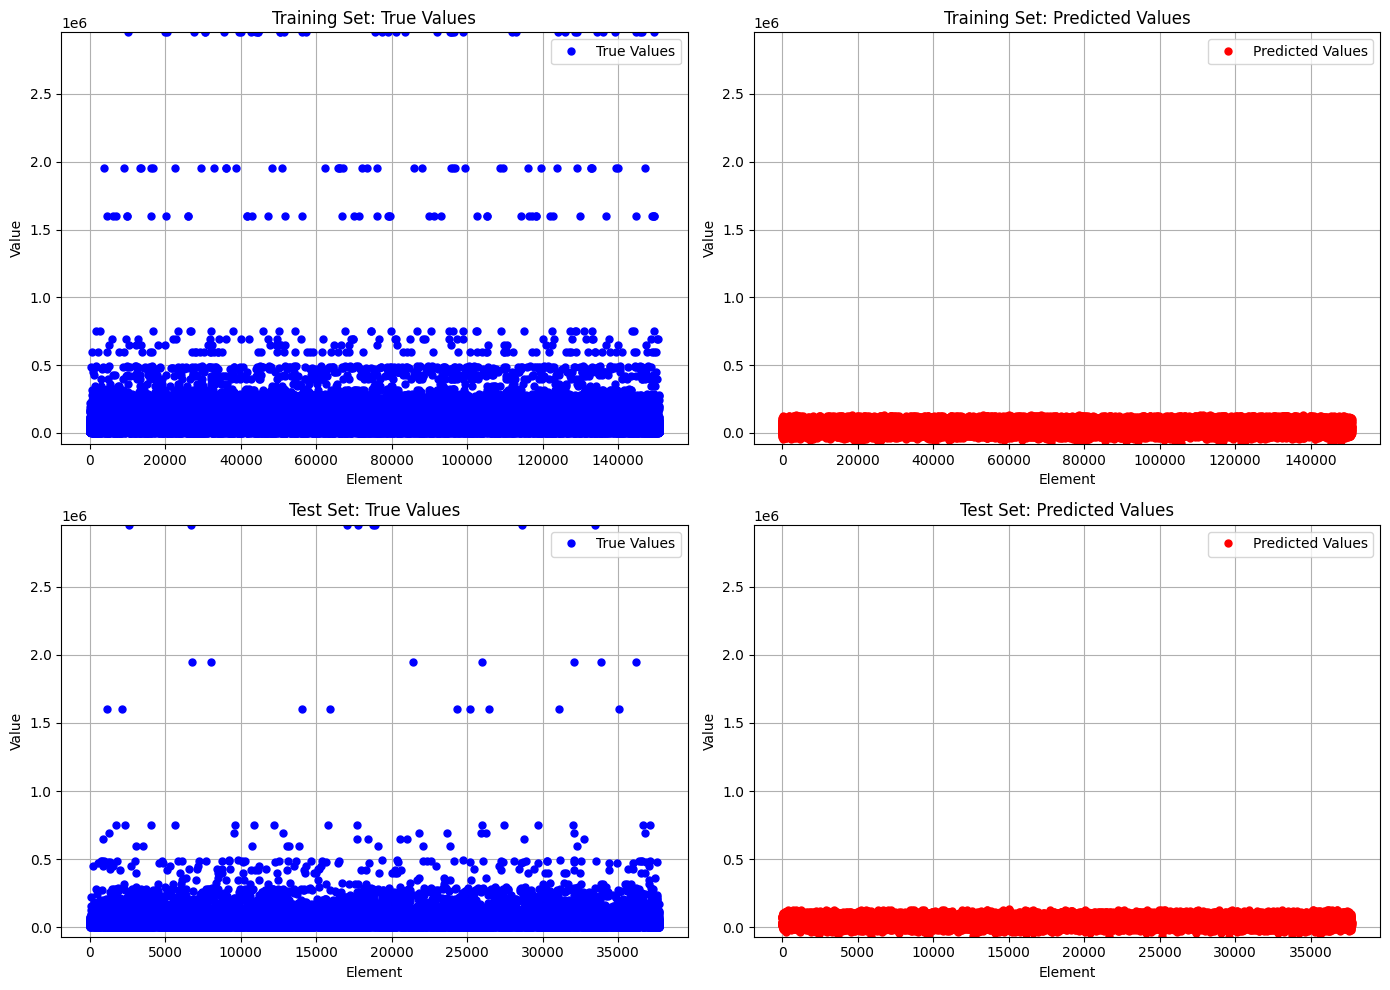

In [55]:
from sklearn.linear_model import Ridge

lr = Ridge()
lr.fit(X_train, y_train)

train_y_pred_lr = lr.predict(X_train)
train_rmse_lr = root_mean_squared_error(train_y_pred_lr, y_train)
print('Train rmse', train_rmse_lr)

test_y_pred_lr = lr.predict(X_test)
test_rmse_lr = root_mean_squared_error(test_y_pred_lr, y_test)
print('Test rmse', test_rmse_lr)

results.loc[len(results)] = ['Linear Regressor', train_rmse_lr, test_rmse_lr]

plot_results(train_rmse_lr, test_rmse_lr, y_train, y_test, train_y_pred_lr, test_y_pred_lr)

Train rmse 40424.13607930502
Test rmse 74616.87933125057


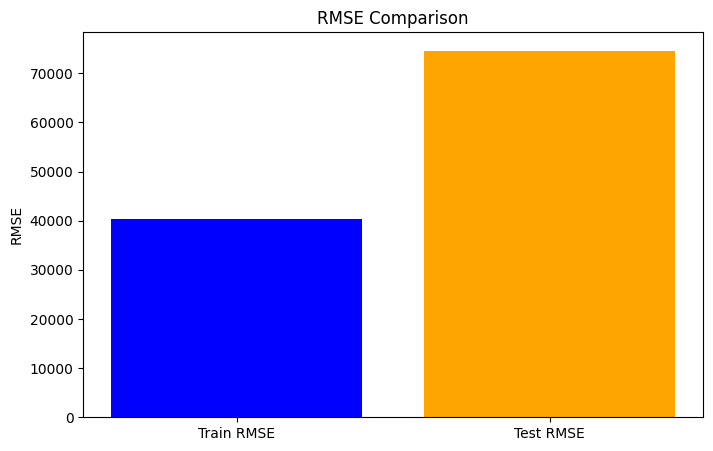

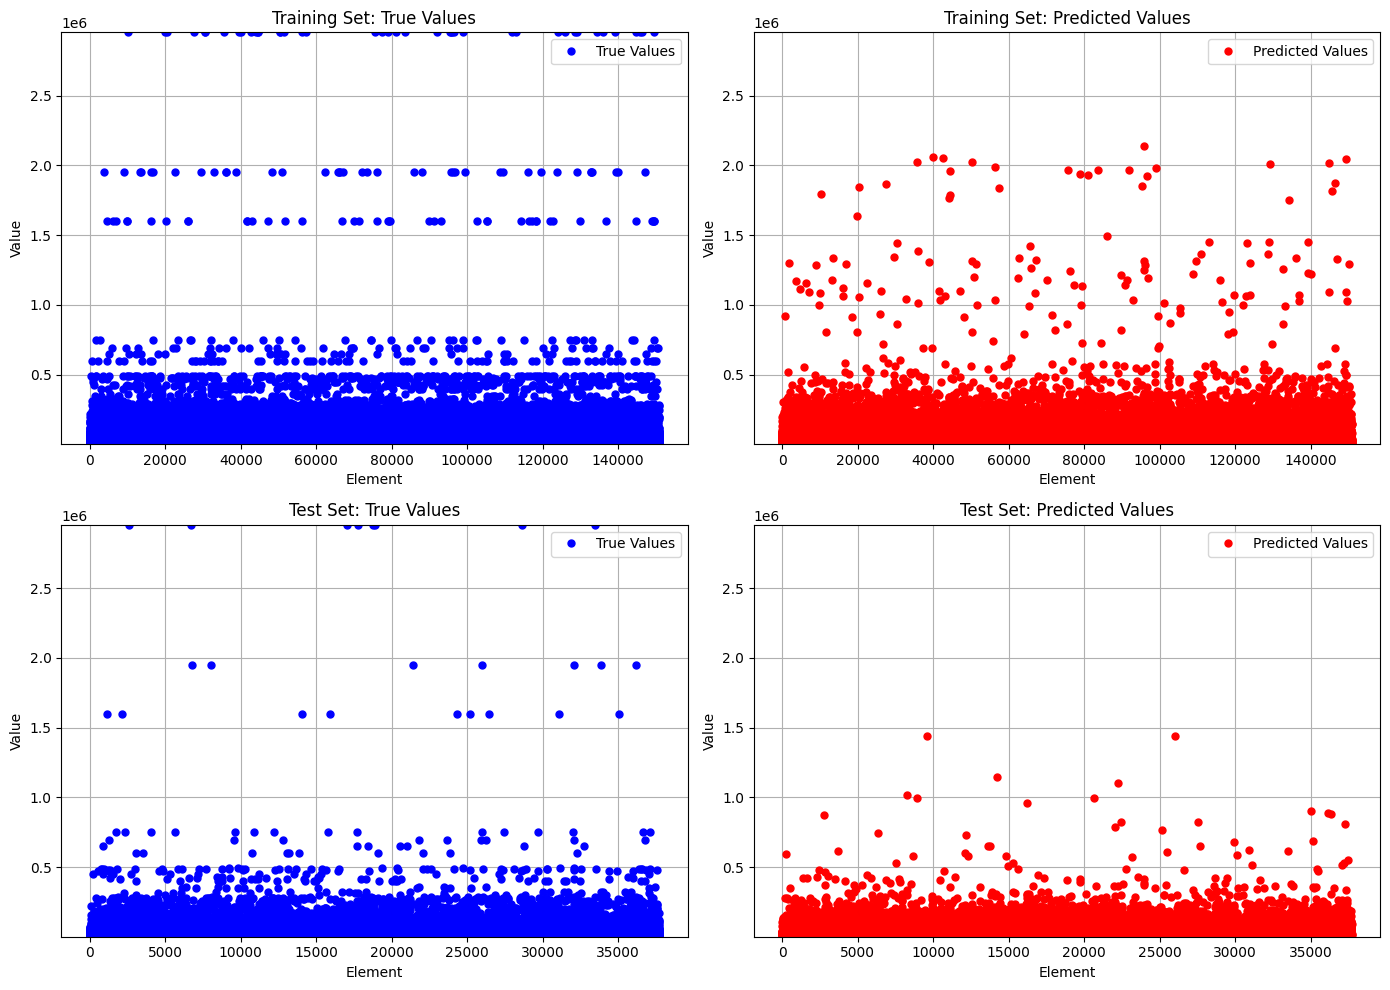

In [56]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
rf.fit(X_train, y_train)

train_y_pred_rf = rf.predict(X_train)
train_rmse_rf = root_mean_squared_error(train_y_pred_rf, y_train)
print('Train rmse', train_rmse_rf)

test_y_pred_rf = rf.predict(X_test)
test_rmse_rf = root_mean_squared_error(test_y_pred_rf, y_test)
print('Test rmse', test_rmse_rf)

results.loc[len(results)] = ['Random Forest Regressor', train_rmse_rf, test_rmse_rf]

plot_results(train_rmse_rf, test_rmse_rf, y_train, y_test, train_y_pred_rf, test_y_pred_rf)

In [66]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

train_y_pred_svr = svr.predict(X_train)
train_rmse_svr = root_mean_squared_error(train_y_pred_svr, y_train)
print('Train rmse', train_rmse_svr)

test_y_pred_svr = svr.predict(X_test)
test_rmse_svr = root_mean_squared_error(test_y_pred_svr, y_test)
print('Test rmse', test_rmse_svr)

results.loc[len(results)] = ['Linear Regressor', train_rmse_svr, test_rmse_svr]

plot_results(train_rmse_svr, test_rmse_svr, y_train, y_test, train_y_pred_svr, test_y_pred_svr)

Train rmse 79694.25124143412
Test rmse 76619.86494786783


Best parameters found: {'max_depth': 10, 'n_estimators': 200}
Train rmse 61760.61581009444
Test rmse 69473.44686950144


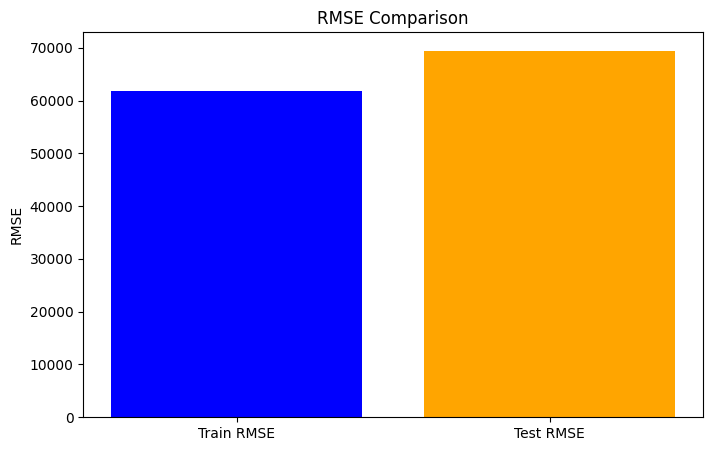

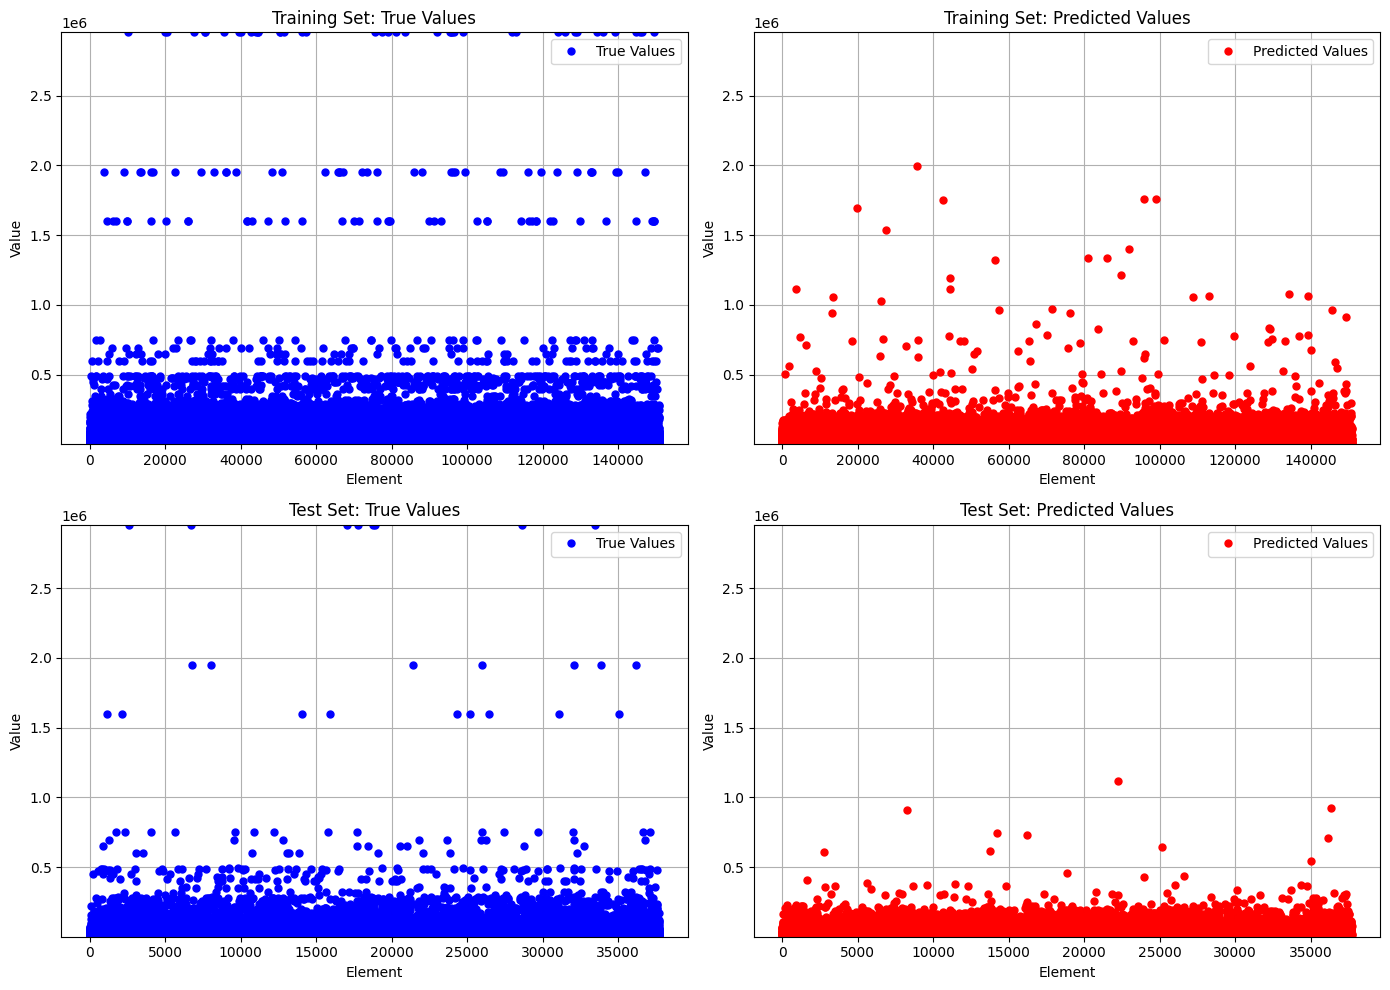

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_regr = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200], # [50, 100, 200],   # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    #'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    #'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required at a leaf node       # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV with RandomForestRegressor and param_grid
grid_search = GridSearchCV(estimator=rf_regr, param_grid=param_grid,
                           cv=5, scoring='neg_root_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Predict on the training set
y_pred_train_rfgs = grid_search.predict(X_train)
train_rmse_rfgs = root_mean_squared_error(y_pred_train_rfgs, y_train)
print('Train rmse', train_rmse_rfgs)


# # Predict on the test set
y_pred_test_rfgs = grid_search.predict(X_test)
test_rmse_rfgs = root_mean_squared_error(y_test, y_pred_test_rfgs)
print('Test rmse', test_rmse_rfgs)

results.loc[len(results)] = ['Random Forest Regressor GS', train_rmse_rfgs, test_rmse_rfgs]

plot_results(train_rmse_rfgs, test_rmse_rfgs, y_train, y_test, y_pred_train_rfgs, y_pred_test_rfgs)

Train rmse 75082.96652646901
Test rmse 69430.36116475351


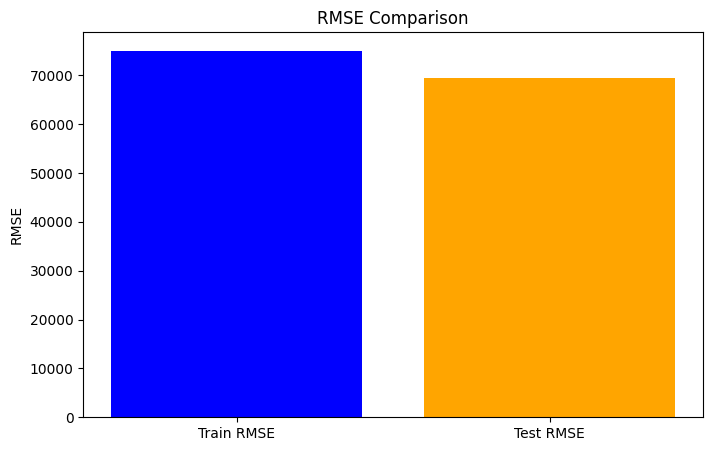

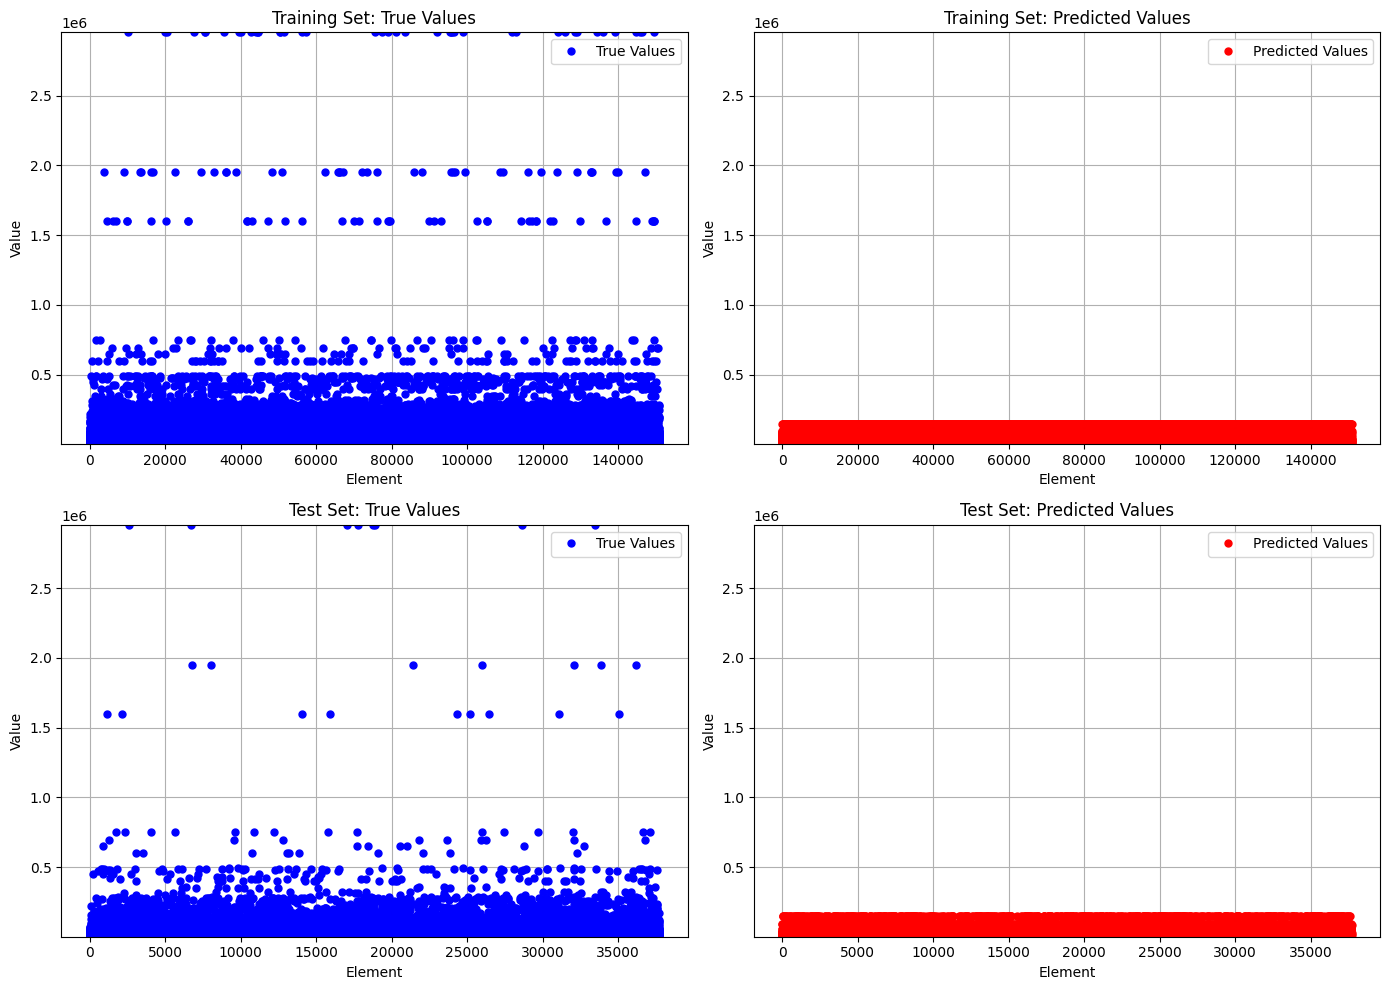

In [57]:
from sklearn.ensemble import AdaBoostRegressor

ab = AdaBoostRegressor(random_state=random_state)
ab.fit(X_train, y_train)

train_y_pred_ab = ab.predict(X_train)
train_rmse_ab = root_mean_squared_error(train_y_pred_ab, y_train)
print('Train rmse', train_rmse_ab)

test_y_pred_ab = ab.predict(X_test)
test_rmse_ab = root_mean_squared_error(test_y_pred_ab, y_test)
print('Test rmse', test_rmse_ab)

results.loc[len(results)] = ['AdaBoost Regressor', train_rmse_ab, test_rmse_ab]

plot_results(train_rmse_ab, test_rmse_ab, y_train, y_test, train_y_pred_ab, test_y_pred_ab)

Train rmse 72780.17614641249
Test rmse 70193.60917236733


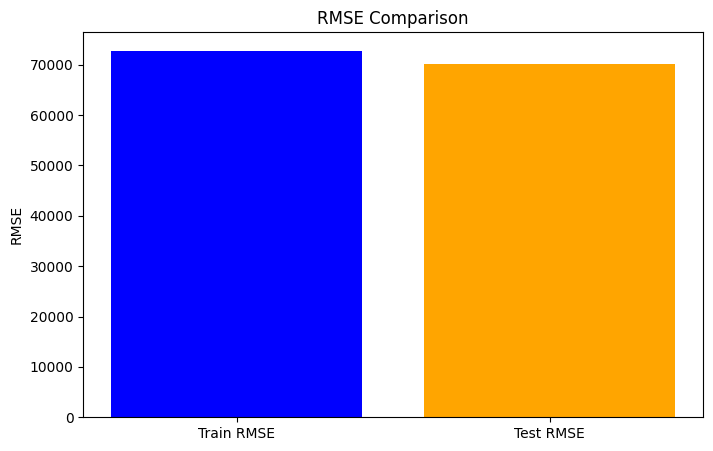

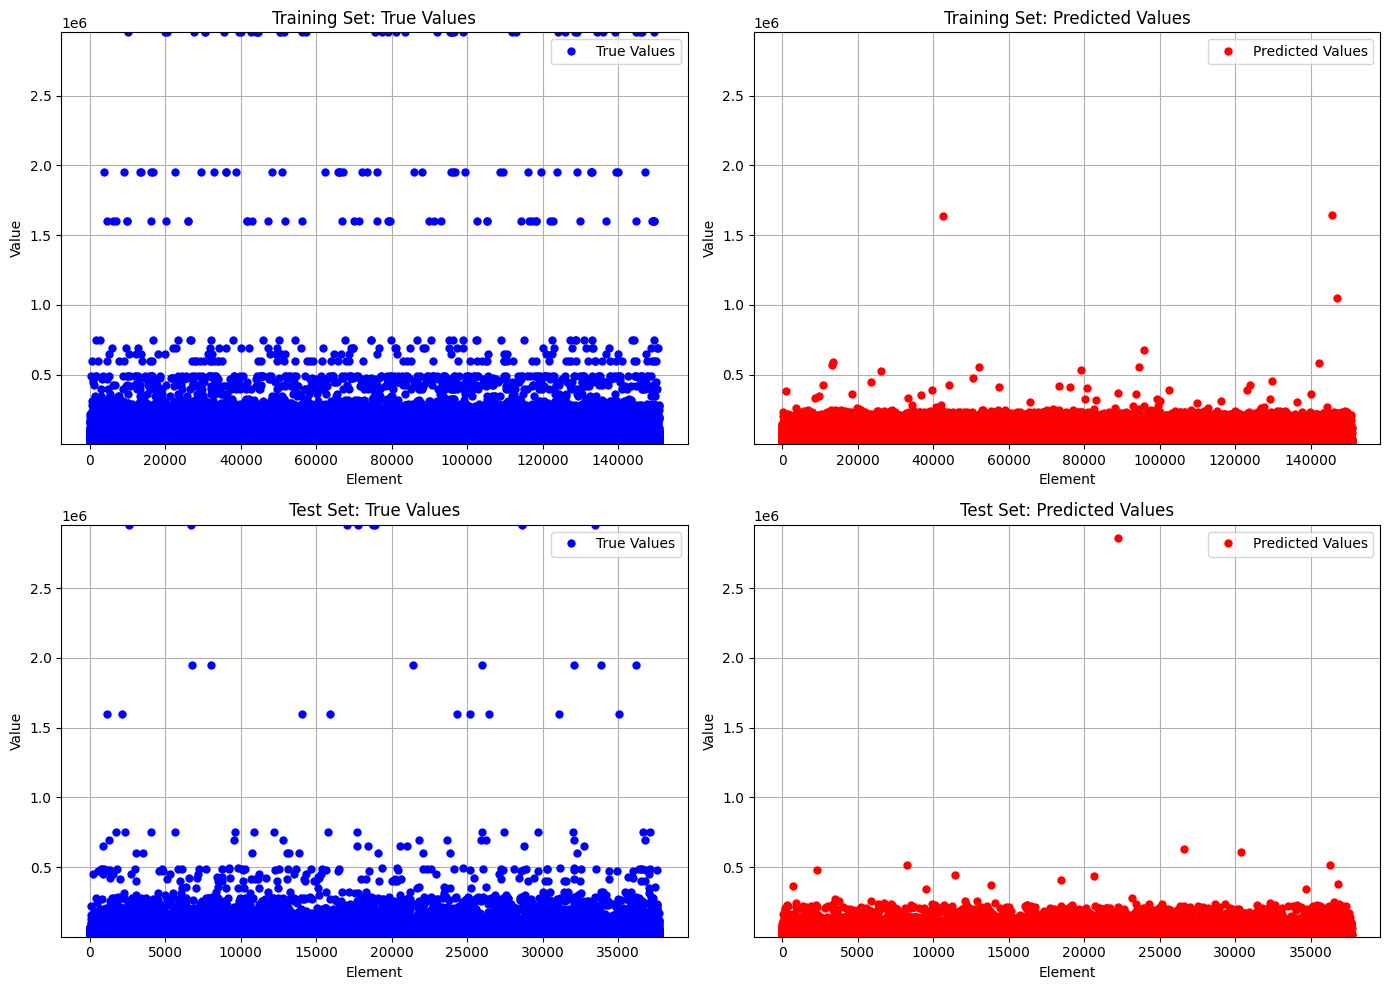

In [41]:
from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor(random_state=random_state, 
                    hidden_layer_sizes=(128, 256, 512, 256, 128), 
                    max_iter=500, 
                    learning_rate='adaptive')

mlpr.fit(X_train, y_train)

train_y_pred_mlpr = mlpr.predict(X_train)
train_rmse_mlpr = root_mean_squared_error(train_y_pred_mlpr, y_train)
print('Train rmse', train_rmse_mlpr)

test_y_pred_mlpr = mlpr.predict(X_test)
test_rmse_mlpr = root_mean_squared_error(test_y_pred_mlpr, y_test)
print('Test rmse', test_rmse_mlpr)

results.loc[len(results)] = ['MLP Regressor', train_rmse_mlpr, test_rmse_mlpr]

plot_results(train_rmse_mlpr, test_rmse_mlpr, y_train, y_test, train_y_pred_mlpr, test_y_pred_mlpr)

In [42]:
results.style.format(precision=0)

,Model,Train RMSE,Test RMSE
0,Linear Regressor,75474,69844
1,Random Forest Regressor,40424,74617
2,AdaBoost Regressor,75083,69430
3,MLP Regressor,72780,70194
